In [ ]:
import sys
import pandas as pd
import numpy as np
import mdtraj as md
import scipy
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [ ]:
proteins      = pd.read_csv('./processed_data/proteins.csv', index_col=0)
proteins_up   = pd.read_csv('./processed_data/proteins_unphcsv', index_col=0)
proteins_ch   = pd.read_csv('./processed_data/proteins.csv', index_col=0)
proteins_mim  = pd.read_csv('./processed_data/proteins_mim.csv', index_col=0)
proteins_ppos = pd.read_csv('./processed_data/proteins_check_ppos.csv', index_col=0)
df_protein    = pd.read_csv('./processed_data/df_protein.csv', index_col=0)
df_protein_ree= pd.read_csv('./processed_data/df_protein_ree.csv', index_col=0)

df_residues_37 = pd.read_csv('./-0.37/residues.csv').set_index('one')
df_residues_37.loc['B','q']=-2
df_residues_37.loc['O','q']=-2
df_residues_00 = pd.read_csv('./0.00/residues.csv').set_index('one')
df_residues_00.loc['B','q']=-2
df_residues_00.loc['O','q']=-2
df_residues_up = pd.read_csv('./unphosphorylated/residues.csv').set_index('one')
df_residues_ch = pd.read_csv('./charged/residues_ch.csv').set_index('one')


delta_lambdas = np.append(np.arange(-.52,0,.05),[0.0])
num_replicas = 3  # Define the number of replicas

### Loading Functions

In [ ]:
def delta_rg(rg_wt,rg_m,rg_wt_err,rg_m_err):
    dRg = rg_m.astype(float)-rg_wt.astype(float)
    dRg_err = np.sqrt(np.power(np.power(rg_m_err.astype(float),2)+rg_wt_err.astype(float),2))
    return dRg, dRg_err


def propagate_error_sum(err1,err2,round=5):
    return np.round(np.sqrt(err1**2+err2**2),round)


def propagate_error_ratio(val1,val2,err1,err2,round=5):
    return np.round(np.sqrt(np.power(err1/val1,2)**2+np.power(err2/val2,2)),round)


### Calculating performance per parameter ###
def chi_squared(exp,exp_err,sim):
    return np.sum((exp-sim)**2/(exp_err)**2)


def rmse(y_true, y_pred):
    """
    Calculate the Root Mean Squared Error (RMSE) between two datasets.

    Parameters:
    y_true (list or np.array): Actual values
    y_pred (list or np.array): Predicted values

    Returns:
    float: RMSE value
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(np.mean((y_true - y_pred) ** 2))


def evaluate_target(protein_names, data, target='rg'):
    indices = []
    # or for lam in lambdas:
    for delta_lambda in delta_lambdas:
        delta_lambda = np.round(delta_lambda,2)
        indices.append(delta_lambda)

    df_par = pd.DataFrame(index=indices,
                          columns=[F'chi2',
                                   F'chi2_ne',
                                   F'mre',
                                   F'mse',
                                   F'rmse',
                                   F'mae',
                                   *[i+'_c2' for i in protein_names],
                                   *[i+'_c2_ne' for i in protein_names],
                                   *[i+'_re' for i in protein_names]])
    for delta_lambda in delta_lambdas:
        delta_lambda = np.round(delta_lambda,2)
        ## Relative error
        temp_rel = []
        for protein,col in zip(protein_names,[i+'_re' for i in protein_names]):
            df_par.loc[delta_lambda,col] = data.loc[(delta_lambda,protein),F'rel_err_{target}']
            temp_rel.append(data.loc[delta_lambda,F'rel_err_{target}'])
        ## Chi-squared w/o error
        temp_chi2_ne = []
        for protein,col in zip(protein_names,[i+'_c2_ne' for i in protein_names]):
            df_par.loc[delta_lambda,col] = data.loc[(delta_lambda,protein),F'chi2_{target}_ne']
            temp_chi2_ne.append(data.loc[(delta_lambda,protein),F'chi2_{target}_ne'])
        ## Chi-squared w error
        temp_chi2 = []
        for protein,col in zip(protein_names,[i+'_c2' for i in protein_names]):
            df_par.loc[delta_lambda,col] = data.loc[(delta_lambda,protein),F'chi2_{target}']
            temp_chi2.append(data.loc[(delta_lambda,protein),F'chi2_{target}'])
        ## Overall metrics       
        df_par.loc[delta_lambda,'mre']     = np.mean(np.abs(temp_rel))
        df_par.loc[delta_lambda,'chi2_ne'] = np.sum(temp_chi2_ne)
        df_par.loc[delta_lambda,'chi2']    = np.sum(temp_chi2)
        df_par.loc[delta_lambda,'mae']     = np.mean(np.abs(np.sqrt(temp_chi2_ne)))
        df_par.loc[delta_lambda,'mse']     = np.mean(temp_chi2_ne)
        df_par.loc[delta_lambda,'rmse']    = np.sqrt(df_par.loc[delta_lambda,'mse'])                                                            
    return df_par


def calcCCC(experiment,simulation):
    exp = experiment
    sim = simulation

    #Calculate the mean of the experimental and simulated set of <E>
    exp_mean = np.mean(exp)
    sim_mean = np.mean(sim)

    #Calculate the standard deviation of the experimental and simulated set of <E>
    exp_std = np.std(exp)
    sim_std = np.std(sim)

    #Calculate Pearson correlation coefficient
    pearsonr = scipy.stats.pearsonr(exp,sim)

    #Calculate scale shift
    nu = exp_std/sim_std
    
    #Calculate location shift relative to the scale
    u = (exp_mean - sim_mean)/np.sqrt(exp_std*sim_std)

    #Calculate Cb
    cb = ((nu+(1/nu)+u**2)/2)**-1

    #Calculate Concordance Correlation Coefficient
    ccc = pearsonr[0]*cb
    return ccc


In [4]:
PtoWT = {'10pAsh1':'Ash1','pCTD2':'CTD2','pSic-6fold':'Sic1','pSic-7fold':'Sic1',
         'HPPAGE4':'WTPAGE4','CPPAGE4':'WTPAGE4','SN15p':'SN15','rOPNp':'rOPN',
         'pERa':'ERa','pTauT':'TauT','pTauS':'TauS'}

WTtoP = {'Ash1':'10pAsh1','CTD2':'pCTD2','Sic1':'pSic-6fold','Sic1':'pSic-7fold',
         'WTPAGE4':'HPPAGE4','WTPAGE4':'CPPAGE4','SN15':'SN15p','rOPN':'rOPNp',
         'ERa':'pERa','TauT':'pTauT','TauS':'pTauS'}

# up_labels=

ph_labels= {'10pAsh1':'pAsh1','pCTD2':'pCTD2','pSic-6fold':'pSic1 (6p)','pSic-7fold':'pSic (7p)',
           'HPPAGE4':'HPPAGE4','CPPAGE4':'CPPAGE4','SN15p':'SN15p','rOPNp':'rOPNp',
           'pERa':'pERa','pTauT':'pTauT','pTauS':'pTauS'}


In [49]:
### Calculating performance per parameter ###
def chi_squared(exp,exp_err,sim):
    return np.sum((exp-sim)**2/(exp_err)**2)


def get_metrics(protein_names, data, descriptor='rg'):
    indices = []
    # or for lam in lambdas:
    for delta_lambda in delta_lambdas:
        delta_lambda = np.round(delta_lambda,2)
        indices.append(delta_lambda)


    df_par = pd.DataFrame(index=indices,
                          columns=[F'chi2_d{descriptor}',F'chi2_ratio',F'chi2_{descriptor}',
                                   F'chi2_d{descriptor}_ne',F'chi2_ratio_ne',F'chi2_{descriptor}_ne',
                                   F'mre_d{descriptor}',F'mre_ratio',F'mre_{descriptor}',
                                   F'mse_d{descriptor}',F'mse_ratio',F'mse_{descriptor}',
                                   F'rmse_d{descriptor}',F'rmse_ratio',F'rmse_{descriptor}',
                                   F'mae_d{descriptor}',F'mae_ratio',F'mae_{descriptor}',
                                   *[i+'_c2d' for i in protein_names],
                                   *[i+'_c2r' for i in protein_names],
                                   *[i+'_c2rat' for i in protein_names],
                                   *[i+'_c2d_ne' for i in protein_names],
                                   *[i+'_c2r_ne' for i in protein_names],
                                   *[i+'_c2rat_ne' for i in protein_names],
                                   *[i+'_red' for i in protein_names],
                                   *[i+'_rer' for i in protein_names],
                                   *[i+'_rerat' for i in protein_names]])

    for delta_lambda in delta_lambdas:
        delta_lambda = np.round(delta_lambda,2)
        temp_rel_drg = []
        for protein,col in zip(protein_names, [i+'_red' for i in protein_names]):
            df_par.loc[delta_lambda,col] = data.loc[(delta_lambda,protein),F'rel_err_d{descriptor}']
            temp_rel_drg.append(data.loc[delta_lambda,F'rel_err_d{descriptor}'])

        temp_rel_rg = []
        for protein,col in zip(protein_names,[i+'_rer' for i in protein_names]):
            df_par.loc[delta_lambda,col] = data.loc[(delta_lambda,protein),F'rel_err_{descriptor}']
            temp_rel_rg.append(data.loc[delta_lambda,F'rel_err_{descriptor}'])

        temp_rel_ratio = []
        for protein,col in zip(protein_names,[i+'_rerat' for i in protein_names]):
            df_par.loc[delta_lambda,col] = data.loc[(delta_lambda,protein),F'rel_err_ratio']
            temp_rel_ratio.append(data.loc[delta_lambda,F'rel_err_ratio'])


            
        temp_chi2_drg_ne = []
        for protein,col in zip(protein_names,[i+'_c2d_ne' for i in protein_names]):
            df_par.loc[delta_lambda,col] = data.loc[(delta_lambda,protein),F'chi2_d{descriptor}_ne']
            temp_chi2_drg_ne.append(data.loc[(delta_lambda,protein),F'chi2_d{descriptor}_ne'])

        temp_chi2_rg_ne = []
        for protein,col in zip(protein_names,[i+'_c2r_ne' for i in protein_names]):
            df_par.loc[delta_lambda,col] = data.loc[(delta_lambda,protein),F'chi2_{descriptor}_ne']
            temp_chi2_rg_ne.append(data.loc[(delta_lambda,protein),F'chi2_{descriptor}_ne'])

        temp_chi2_ratio_ne = []
        for protein,col in zip(protein_names,[i+'_c2rat_ne' for i in protein_names]):
            df_par.loc[delta_lambda,col] = data.loc[(delta_lambda,protein),F'chi2_ratio_ne']
            temp_chi2_ratio_ne.append(data.loc[(delta_lambda,protein),F'chi2_ratio_ne'])



        temp_chi2_drg = []
        for protein,col in zip(protein_names,[i+'_c2d' for i in protein_names]):
            df_par.loc[delta_lambda,col] = data.loc[(delta_lambda,protein),F'chi2_d{descriptor}']
            temp_chi2_drg.append(data.loc[(delta_lambda,protein),F'chi2_d{descriptor}'])

        temp_chi2_rg = []
        for protein,col in zip(protein_names,[i+'_c2r' for i in protein_names]):
            df_par.loc[delta_lambda,col] = data.loc[(delta_lambda,protein),F'chi2_{descriptor}']
            temp_chi2_rg.append(data.loc[(delta_lambda,protein),F'chi2_{descriptor}'])
        
        temp_chi2_ratio = []
        for protein,col in zip(protein_names,[i+'_c2rat' for i in protein_names]):
            df_par.loc[delta_lambda,col] = data.loc[(delta_lambda,protein),F'chi2_ratio']
            temp_chi2_ratio.append(data.loc[(delta_lambda,protein),F'chi2_ratio'])


        df_par.loc[delta_lambda,F'mre_d{descriptor}'] = np.mean(temp_rel_drg)
        df_par.loc[delta_lambda,F'mre_{descriptor}'] = np.mean(temp_rel_rg)
        df_par.loc[delta_lambda,F'mre_ratio'] = np.mean(temp_rel_ratio)
        df_par.loc[delta_lambda,F'chi2_d{descriptor}_ne'] = np.sum(temp_chi2_drg_ne)
        df_par.loc[delta_lambda,F'chi2_{descriptor}_ne']  = np.sum(temp_chi2_rg_ne)
        df_par.loc[delta_lambda,F'chi2_ratio_ne']  = np.sum(temp_chi2_ratio_ne)
        df_par.loc[delta_lambda,F'chi2_d{descriptor}'] = np.sum(temp_chi2_drg)
        df_par.loc[delta_lambda,F'chi2_{descriptor}']  = np.sum(temp_chi2_rg)
        df_par.loc[delta_lambda,F'chi2_ratio']  = np.sum(temp_chi2_ratio)
        
        # Some additional metrics
        df_par.loc[delta_lambda,F'mse_d{descriptor}']    = np.mean(temp_chi2_drg_ne)
        df_par.loc[delta_lambda,F'mse_{descriptor}']     = np.mean(temp_chi2_rg_ne)
        df_par.loc[delta_lambda,F'mse_ratio']  = np.mean(temp_chi2_ratio_ne)
        df_par.loc[delta_lambda,F'rmse_d{descriptor}']   = np.sqrt(df_par.loc[delta_lambda,F'mse_d{descriptor}'])
        df_par.loc[delta_lambda,F'rmse_{descriptor}']    = np.sqrt(df_par.loc[delta_lambda,F'mse_{descriptor}'])
        df_par.loc[delta_lambda,F'rmse_ratio'] = np.sqrt(df_par.loc[delta_lambda,F'mse_ratio'])                                                            
    return df_par

### Dataset Figures

#### Figure 1

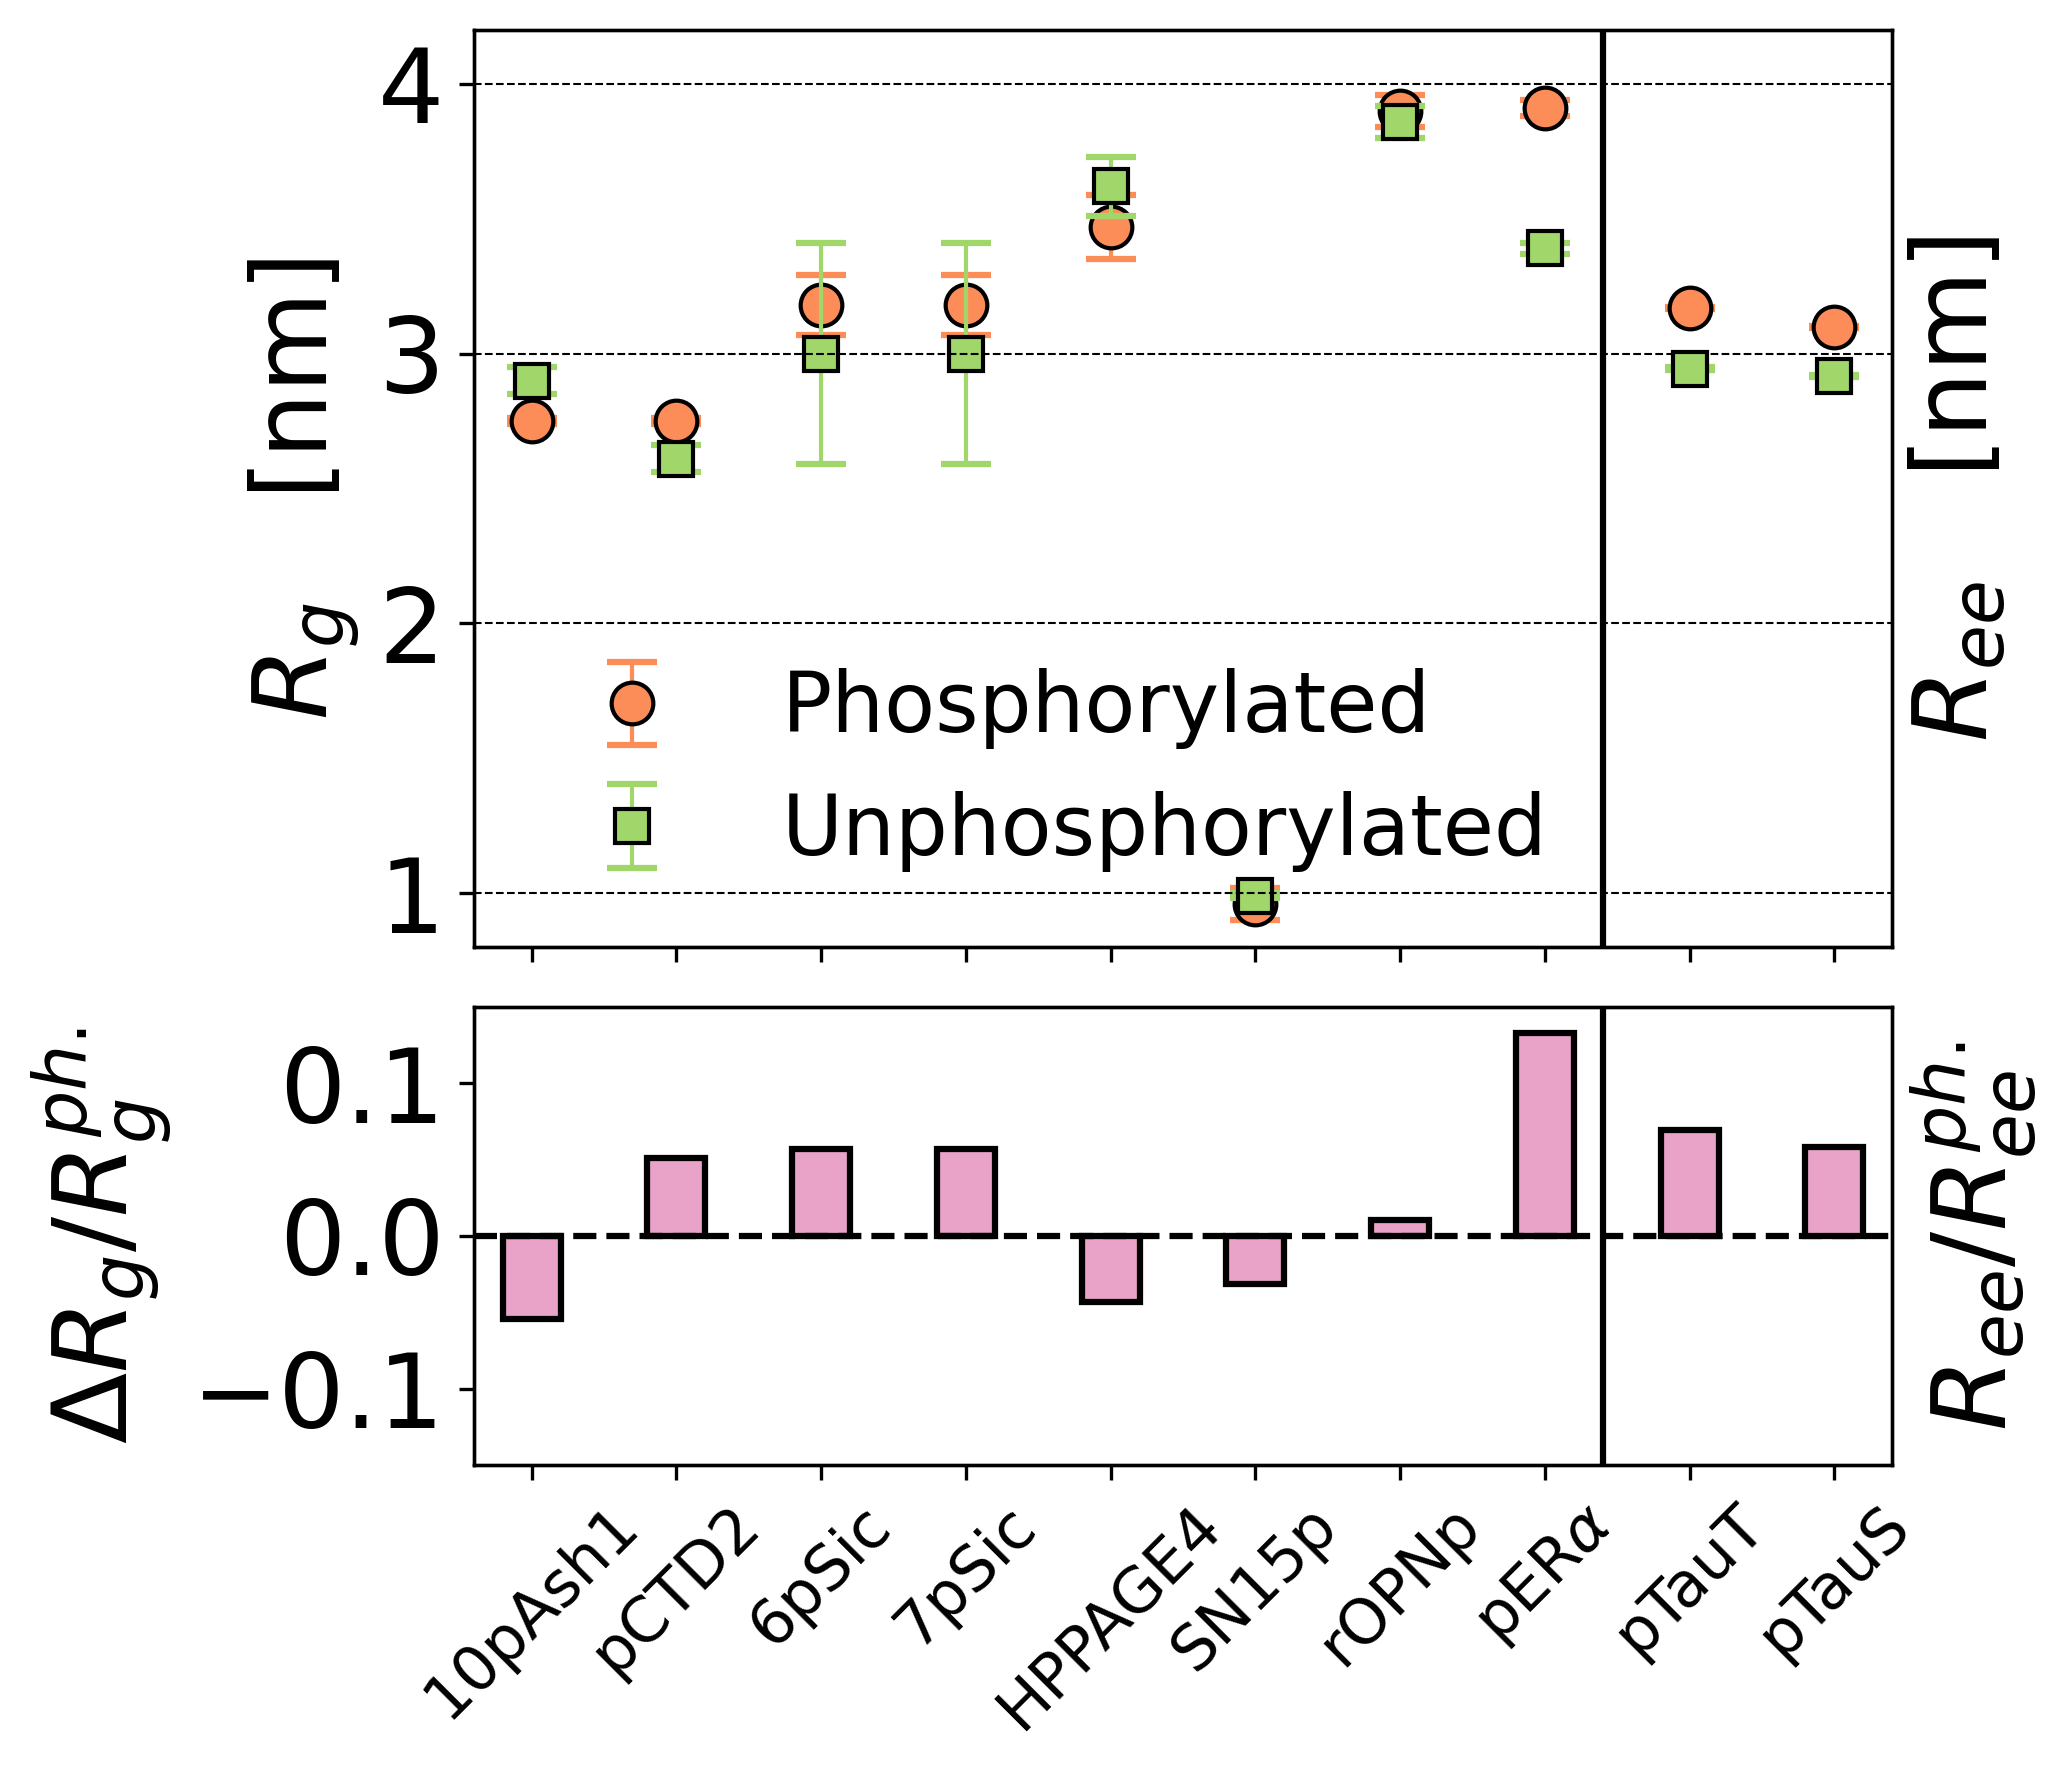

In [ ]:
prot_labels = ['10pAsh1', 'pCTD2', '6pSic', '7pSic', 'HPPAGE4', 'SN15p', 'rOPNp', r'pER$\alpha$','pTauT','pTauS']


fig, axs = plt.subplots(2,1,figsize=(7,6),dpi=300,sharex=True,gridspec_kw={'height_ratios':[2,1]});
x_axis = np.arange(len(prots_rg_new))
# Multi bar Chart
axs[0].errorbar(x=x_axis/2,
                y=df_protein.loc[(-0.37),'exp_rg'].loc[prots_rg_new],
                yerr=df_protein.loc[(-0.37),'exp_rg_err'].loc[prots_rg_new],
                #width=0.3,
                marker='o',ms=10,elinewidth=1,capsize=6,capthick=1.5,ls='',
                label = 'Phosphorylated',lw=1.5,color='#fc8d59',markeredgecolor='black',zorder=0)
axs[0].errorbar(x=x_axis/2,
                y=[proteins_up.loc[PtoWT[prot],"exp_rg"] for prot in prots_rg_new],
                yerr=[proteins_up.loc[PtoWT[prot],"exp_rg_err"] for prot in prots_rg_new],
                #width=0.15,
                marker='s',ms=8,elinewidth=1,capsize=6,capthick=1.5,ls='',
                label = 'Unphosphorylated',  lw=1.5,color='#a1d76a',markeredgecolor='black',zorder=1)


axs[0].hlines([1,2,3,4],-1,4.7,color='k',ls='--',linewidth=0.5)
axs[0].vlines(3.7,0.6,4.3,color='k',ls='-',linewidth=1.5)
axs[0].set_ylim(0.8,4.2)

# Xticks
axs[0].tick_params(axis="y", labelsize=25)
axs[0].set_ylabel("$R_{g}$   [nm]", fontsize=25)
# Add legend
axs[0].legend(frameon=False,title_fontsize=25,fontsize=20,loc='lower left',ncol=1);

# Ree data
ax0 = axs[0].twinx()
ax0.errorbar(x=[4.,4.5],
             y=df_protein_ree.loc[(-0.37),'exp_ree'].loc[prots_ree],
             yerr=df_protein_ree.loc[(-0.37),'exp_ree_err'].loc[prots_ree],
             #width=0.3,
             marker='o',ms=10,elinewidth=1,capsize=6,capthick=1.5,ls='',
             # label = '$R_{g}^{ph}$',
             lw=1.5,color='#fc8d59',markeredgecolor='black',zorder=0)
ax0.errorbar(x=[4.,4.5],
             y=[proteins_up.loc[PtoWT[prot],"exp_ree"] for prot in prots_ree],
             yerr=[proteins_up.loc[PtoWT[prot],"exp_ree_err"] for prot in prots_ree],
             #width=0.15,
             marker='s',ms=8,elinewidth=1,capsize=6,capthick=1.5,ls='',
             # label = '$R_{g}^{unph}$',
             lw=1.5,color='#a1d76a',markeredgecolor='black',zorder=1)

ax0.set_ylabel("$R_{ee}$   [nm]", fontsize=25)
ax0.set_yticks([])#2.5,3.0,3.5])
ax0.set_ylim(0.8,4.2)
ax0.tick_params(axis="y", labelsize=25)



############
## Ratio Rg ##
exp_drgs       = [np.round(df_protein.loc[(-0.37),'exp_rg'].loc[prot] - proteins_up.loc[PtoWT[prot],"exp_rg"],2) for prot in prots_rg_new]
exp_drgs_err   = [propagate_error_sum(df_protein.loc[(-0.37),'exp_rg_err'].loc[prot],proteins_up.loc[PtoWT[prot],"exp_rg_err"],round=2) for prot in prots_rg_new]
exp_ratios     = exp_drgs / np.array([df_protein.loc[(-0.37),'exp_rg'].loc[prot] for prot in prots_rg_new])
exp_ratios_err = propagate_error_ratio(val1=np.array(exp_drgs),
                                       val2=np.array([df_protein.loc[(-0.37),'exp_rg'].loc[prot] for prot in prots_rg_new]),
                                       err1=np.array(exp_drgs_err),
                                       err2=np.array([df_protein.loc[(-0.37),'exp_rg_err'].loc[prot] for prot in prots_rg_new]),round=3)
## Ratio Ree ##
exp_drees         = [np.round(df_protein_ree.loc[(-0.37),'exp_ree'].loc[prot] - proteins_up.loc[PtoWT[prot],"exp_ree"],2) for prot in prots_ree]
exp_drees_err     = [propagate_error_sum(df_protein_ree.loc[(-0.37),'exp_ree_err'].loc[prot],proteins_up.loc[PtoWT[prot],"exp_ree_err"],round=2) for prot in prots_ree]
exp_ratios_ee     = exp_drees / np.array([df_protein_ree.loc[(-0.37),'exp_ree'].loc[prot] for prot in prots_ree])
exp_ratios_ee_err = propagate_error_ratio(val1=np.array(exp_drees),
                                          val2=np.array([df_protein_ree.loc[(-0.37),'exp_ree'].loc[prot] for prot in prots_ree]),
                                          err1=np.array(exp_drees_err),
                                          err2=np.array([df_protein_ree.loc[(-0.37),'exp_ree_err'].loc[prot] for prot in prots_ree]),round=3)

axs[1].bar(x_axis/2,
           exp_ratios,
           width=0.2,
           label = '$\Delta R_{g}$',
           lw=1.5,
           color='#e9a3c9',
           edgecolor='black')

ax1 = axs[1].twinx()
ax1.bar([4.,4.5],
         exp_ratios_ee,
         width=0.2,
         label = '$\Delta R_{ee}$',
         lw=1.5,
         color='#e9a3c9',
         edgecolor='black')

ax1.set_ylabel("$R_{ee}/R_{ee}^{ph}$", fontsize=25)
ax1.set_yticks([])#[-.1,0.0,.1])
ax1.set_ylim(-0.15,0.15)
ax1.tick_params(axis="y", labelsize=25)


# Xticks
axs[1].set_xticks(np.arange(10)/2)#x_axis/2)
axs[1].set_xticklabels(prot_labels,rotation=-60)
axs[1].set_yticks([-0.1,0,0.1])
axs[1].tick_params(axis="x", labelsize=15,rotation=45) 
axs[1].tick_params(axis="y", labelsize=25)
axs[1].set_ylabel("$\Delta R_{g}/R_{g}^{ph}$", fontsize=25)

axs[1].vlines(3.7,-0.6,0.6,color='k',ls='-',linewidth=1.5)
axs[1].set_ylim(-0.15,0.15)
axs[1].hlines(0,-1,8,color='k',ls='--')
axs[1].set_xlim(-0.2,4.7)

fig.tight_layout()

fig.savefig("./figures/figure1__Rg-Ree-experimental__V3.pdf",bbox_inches='tight', pad_inches=1)


### Parameterisation Figures

#### Figure 2

##### Panel AB: RMSE v. dl & Sim. v Exp.

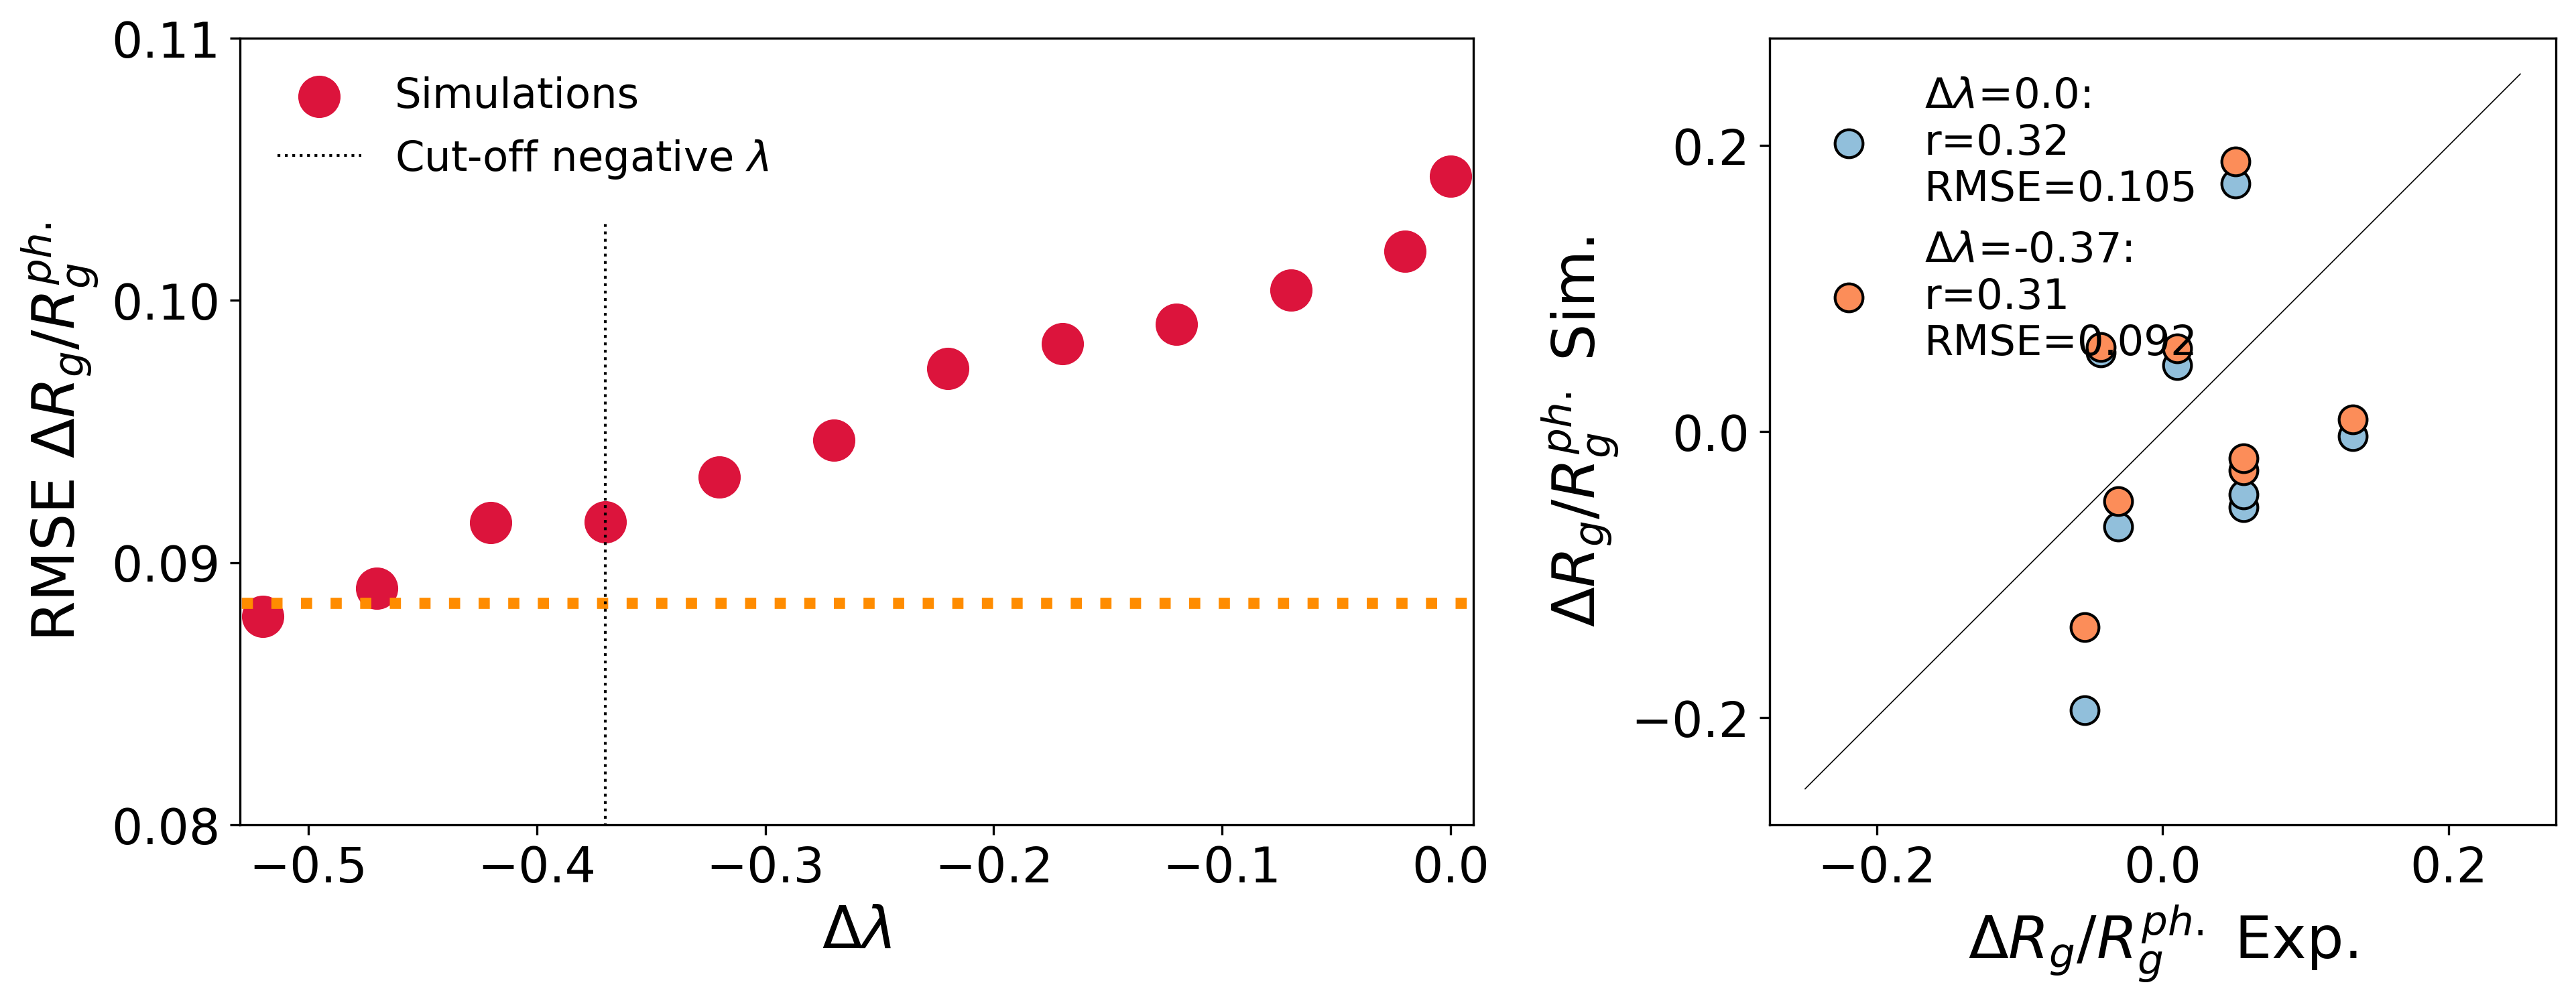

In [ ]:
prots_rg_new = ['10pAsh1', 'pCTD2', 'pSic-6fold', 'pSic-7fold', 'HPPAGE4', 'SN15p', 'rOPNp', 'pERa']
df_temp = evaluate_target(protein_names=prots_rg_new, data=df_protein, target='ratio')
corr=0.7

fig, axs = plt.subplots(1,2,figsize=(13,5),dpi=300,gridspec_kw={'width_ratios': [3, 2]});

targ = 'ratio'
met = 'rmse'
lab='RMSE $\Delta R_{g}/R_{g}^{ph}$'
df_temp = evaluate_target(protein_names=prots_rg_new, data=df_protein, target=targ)
xs=np.array([np.round(float(i),2) for i in df_temp.index])
ys=df_temp[met]
axs[0].hlines(np.mean(ys.to_numpy()[-30:-10]),xs[0],xs[-1]+0.05,linewidth=4,ls=':',color='darkorange')
axs[0].scatter(x=xs, y=ys, s=200, c='crimson',label=F"Simulations")
axs[0].vlines(-0.37,ys.min()-0.05,0.103,ls=':',linewidth=1,color='k',label='Cut-off negative $\lambda$')
axs[0].set_ylabel(F"{lab}",fontsize=30*corr)
axs[0].tick_params(axis='y', labelsize=25*corr)
axs[0].set_yticks([0.08,0.09,0.1,0.11])
axs[0].set_xlabel("$\Delta \lambda$",fontsize=30*corr)
axs[0].tick_params(axis='x', labelsize=25*corr)
axs[0].set_xlim(-.53,0.01)
axs[0].set_ylim(0.08,0.11)
axs[0].legend(fontsize=15,ncol=1,frameon=False,loc='upper left');


### Simulatio vs. Experiement
axs[1].errorbar(x=df_protein.loc[(0.0),'exp_ratio_rg'].loc[prots_rg_new],
             y=df_protein.loc[(0.0),'ratio_rg'].loc[prots_rg_new],
             marker='o', ls='',
             label="$\Delta \lambda$=0.0:\n"+F"r={pearsonr(df_protein.loc[(0.0),'exp_ratio_rg'].loc[prots_rg_new],df_protein.loc[(0.0),'ratio_rg'].loc[prots_rg_new]).statistic:.2f}\nRMSE={df_temp.loc[0.0,'rmse']:.3f}",
             markersize=10,capsize=5,capthick=1,elinewidth=1,color='#91bfdb', markeredgecolor='k')


axs[1].errorbar(x=df_protein.loc[(-0.37),'exp_ratio_rg'].loc[prots_rg_new],
             y=df_protein.loc[(-0.37),'ratio_rg'].loc[prots_rg_new],
             marker='o', ls='',
             label="$\Delta \lambda$=-0.37:\n"+F"r={pearsonr(df_protein.loc[(-0.37),'exp_ratio_rg'].loc[prots_rg_new],df_protein.loc[(-0.37),'ratio_rg'].loc[prots_rg_new]).statistic:.2f}\nRMSE={df_temp.loc[-0.37,'rmse']:.3f}",
             markersize=10,capsize=5,capthick=1,elinewidth=1,color='#fc8d59', markeredgecolor='k')

axs[1].plot(np.arange(-25,26)/100,np.arange(-25,26)/100,color='k',lw=0.4)
axs[1].set_xlabel('$\Delta R_{g}/R_{g}^{ph}$ Exp.',fontsize=30*corr)
axs[1].set_ylabel('$\Delta R_{g}/R_{g}^{ph}$ Sim.',fontsize=30*corr)
axs[1].tick_params(axis='y', labelsize=25*corr)
axs[1].tick_params(axis='x', labelsize=25*corr)
axs[1].set_xticks([-0.2,0.0,0.2])
axs[1].set_yticks([-0.2,0.0,0.2])
axs[1].legend(fontsize=15,ncol=1,frameon=False);
axs[1].set_aspect('equal', 'box');

fig.tight_layout()
fig.savefig("./figures/figure2__top-pane_V2.pdf",bbox_inches='tight', pad_inches=1);

##### Panel C: Relative and squared errors

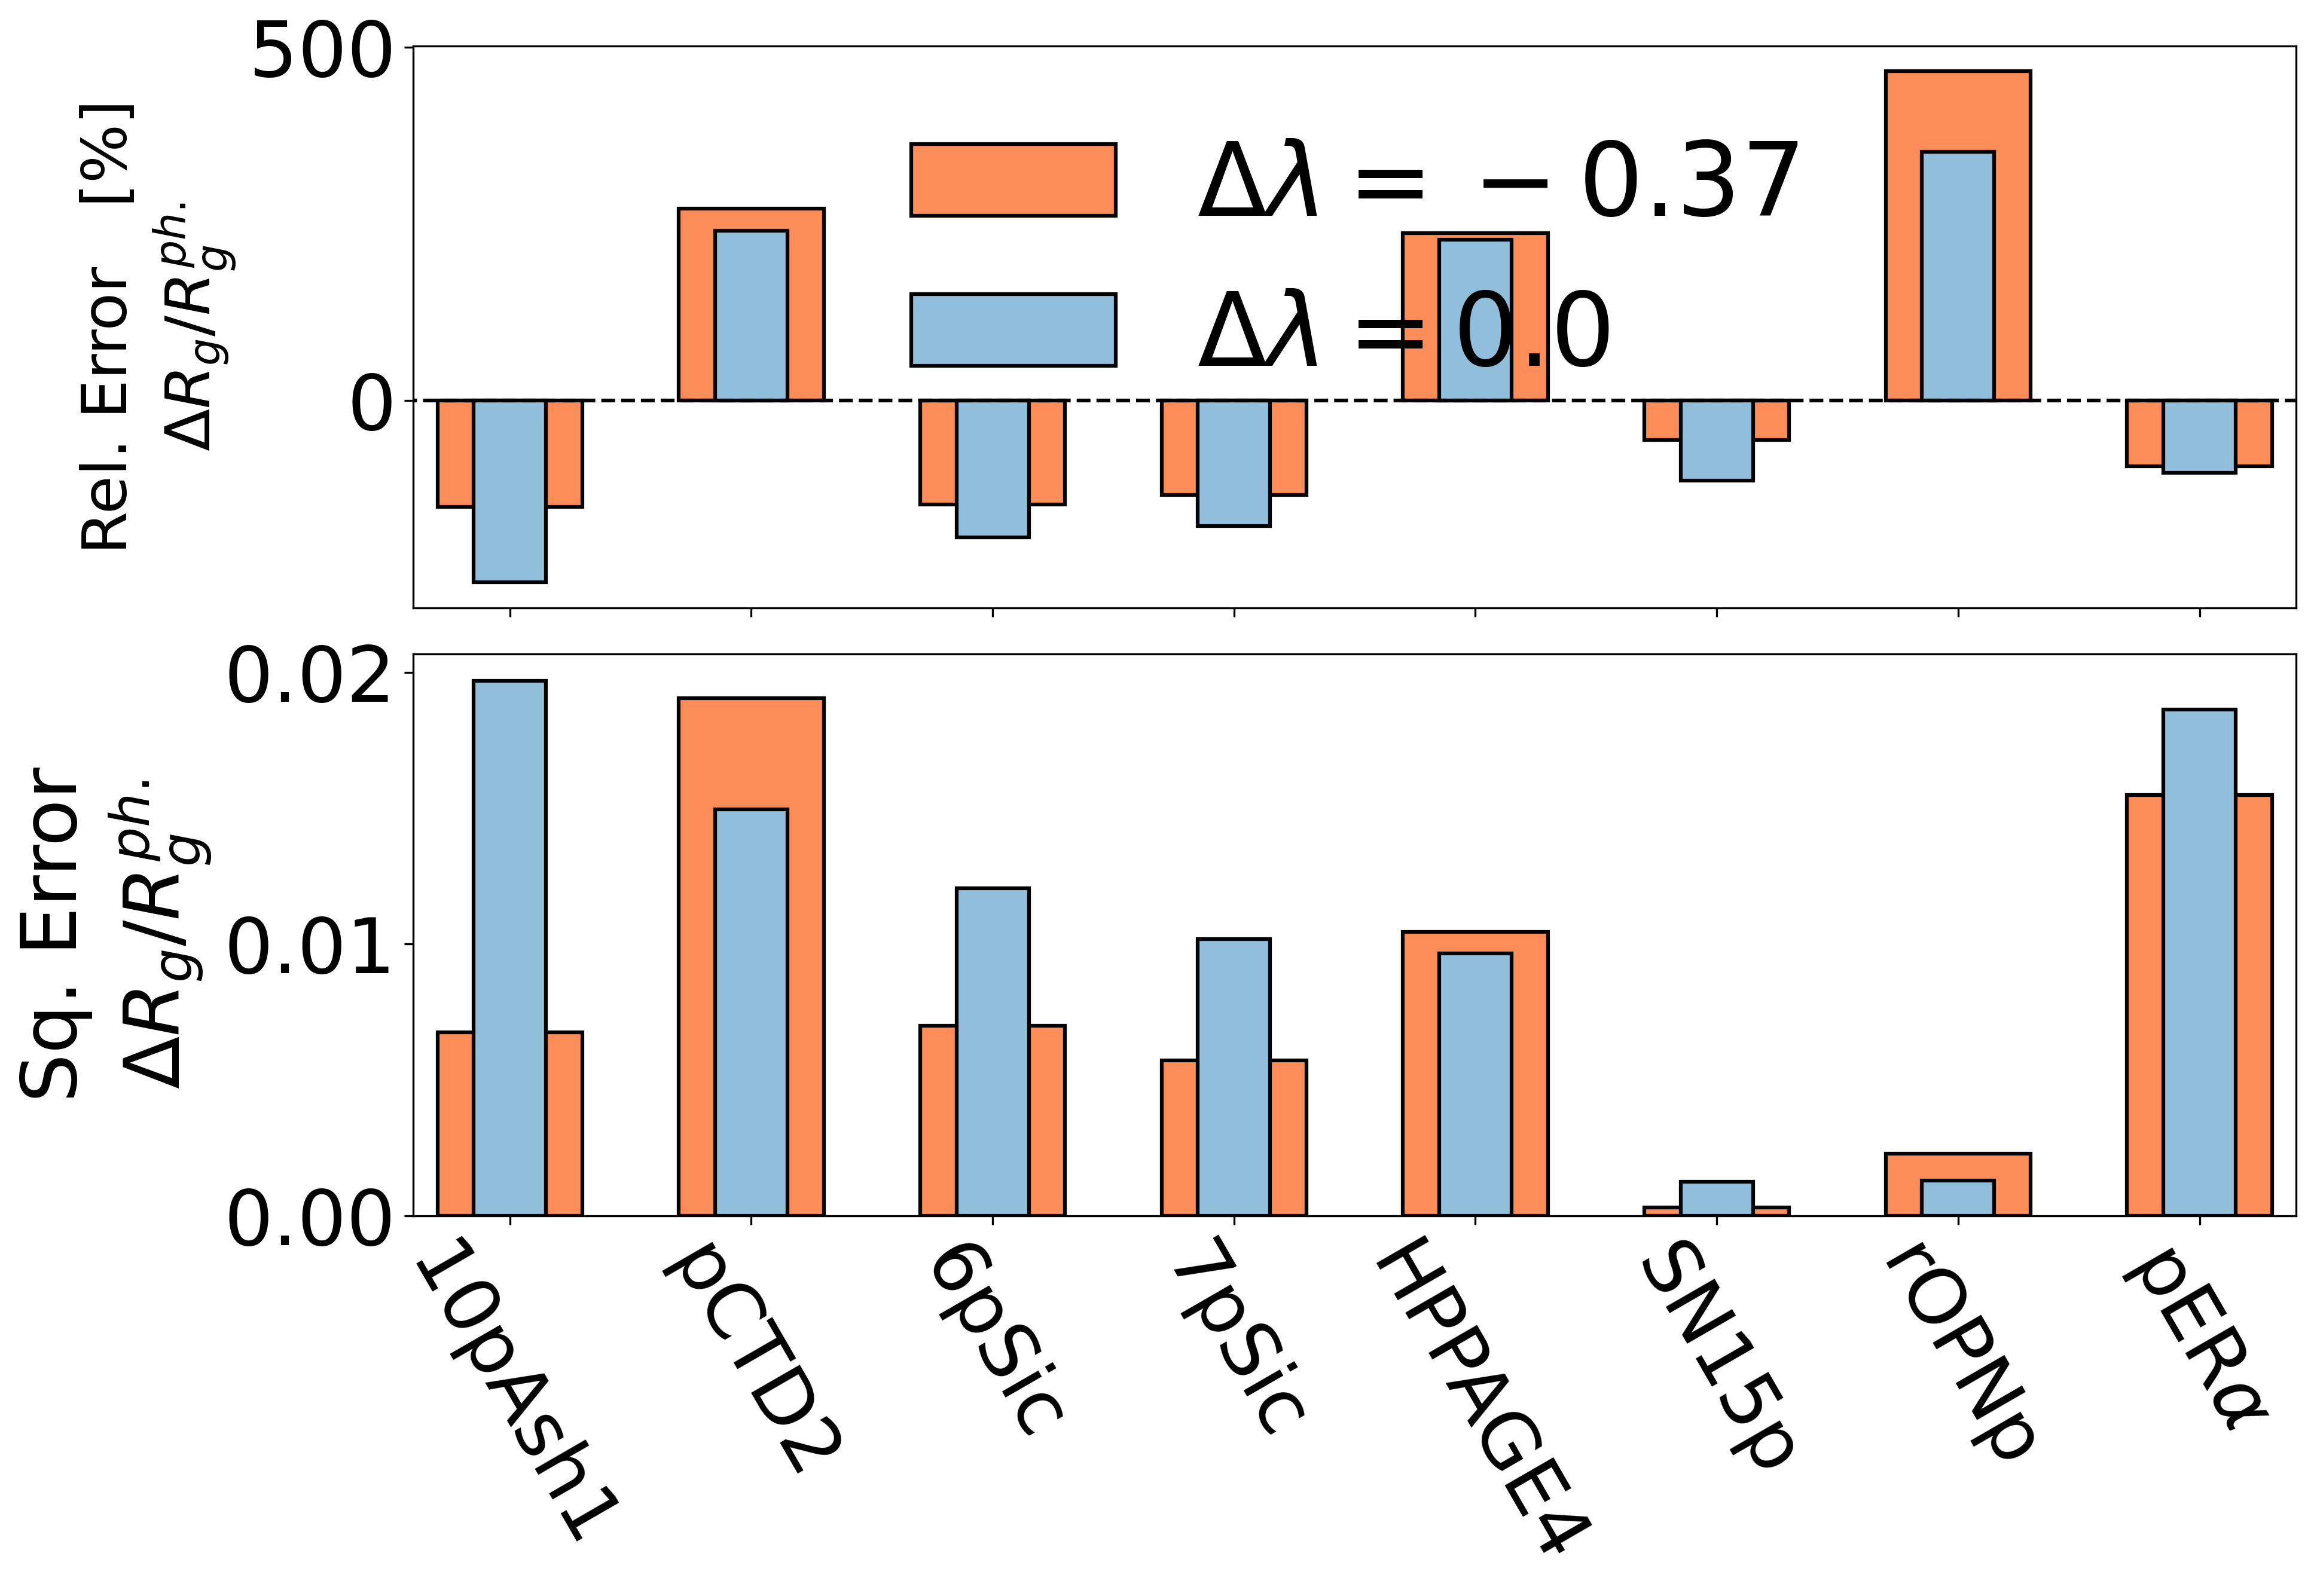

In [ ]:
prots_rg_new = ['10pAsh1', 'pCTD2', 'pSic-6fold', 'pSic-7fold', 'HPPAGE4', 'SN15p', 'rOPNp', 'pERa']
prot_labels = ['10pAsh1', 'pCTD2', '6pSic', '7pSic', 'HPPAGE4', 'SN15p', 'rOPNp', r'pER$\alpha$']
df_temp = evaluate_target(protein_names=prots_rg_new, data=df_protein, target='ratio')
ext=6

fig, axs = plt.subplots(2,1,figsize=(13,9),dpi=300,sharex=True);
x_axis = np.arange(len(prots_rg_new))
# Multi bar Chart
axs[0].bar(x_axis/2, 100*np.array([df_temp.loc[-0.37,prot+"_re"] for prot in prots_rg_new]),
           width=0.3, label = '$\Delta \lambda=-0.37$',lw=1.5,color='#fc8d59',edgecolor='black',zorder=0)
axs[0].bar(x_axis/2, 100*np.array([df_temp.loc[0.0,prot+"_re"] for prot in prots_rg_new]),
           width=0.15, label = '$\Delta \lambda=0.0$',  lw=1.5,color='#91bfdb',edgecolor='black',zorder=1)


# Xticks
axs[0].tick_params(axis="y", labelsize=25+ext)
axs[0].set_ylabel("Rel. Error   [%]\n$\Delta R_{g}/R_{g}^{ph}$", fontsize=25)

axs[1].bar(x_axis/2, [df_temp.loc[-0.37,prot+"_c2_ne"] for prot in prots_rg_new],
           width=0.3, label = '$\Delta \lambda=-0.37$',lw=1.5,color='#fc8d59',edgecolor='black')
axs[1].bar(x_axis/2, [df_temp.loc[0.0,prot+"_c2_ne"] for prot in prots_rg_new],
           width=0.15, label = '$\Delta \lambda=0.0$',  lw=1.5,color='#91bfdb',edgecolor='black',zorder=1)
# Xticks
axs[1].set_xticks(x_axis/2)
axs[1].set_xticklabels(prot_labels,rotation=-60)
axs[1].tick_params(axis="x", labelsize=25+ext) 
axs[1].tick_params(axis="y", labelsize=25+ext)
axs[1].set_ylabel("Sq. Error\n$\Delta R_{g}/R_{g}^{ph}$", fontsize=25+ext)
axs[0].legend(frameon=False,title_fontsize=25,fontsize=35+ext,loc='upper center');
axs[0].hlines(0,-1,8,color='k',ls='--')
axs[0].set_xlim(-0.2,3.7)

fig.tight_layout()
fig.savefig("./figures/figure2__panel-C__barplots-errors_V3.pdf",bbox_inches='tight', pad_inches=1);

##### Panel D: 6pSic1 patterning

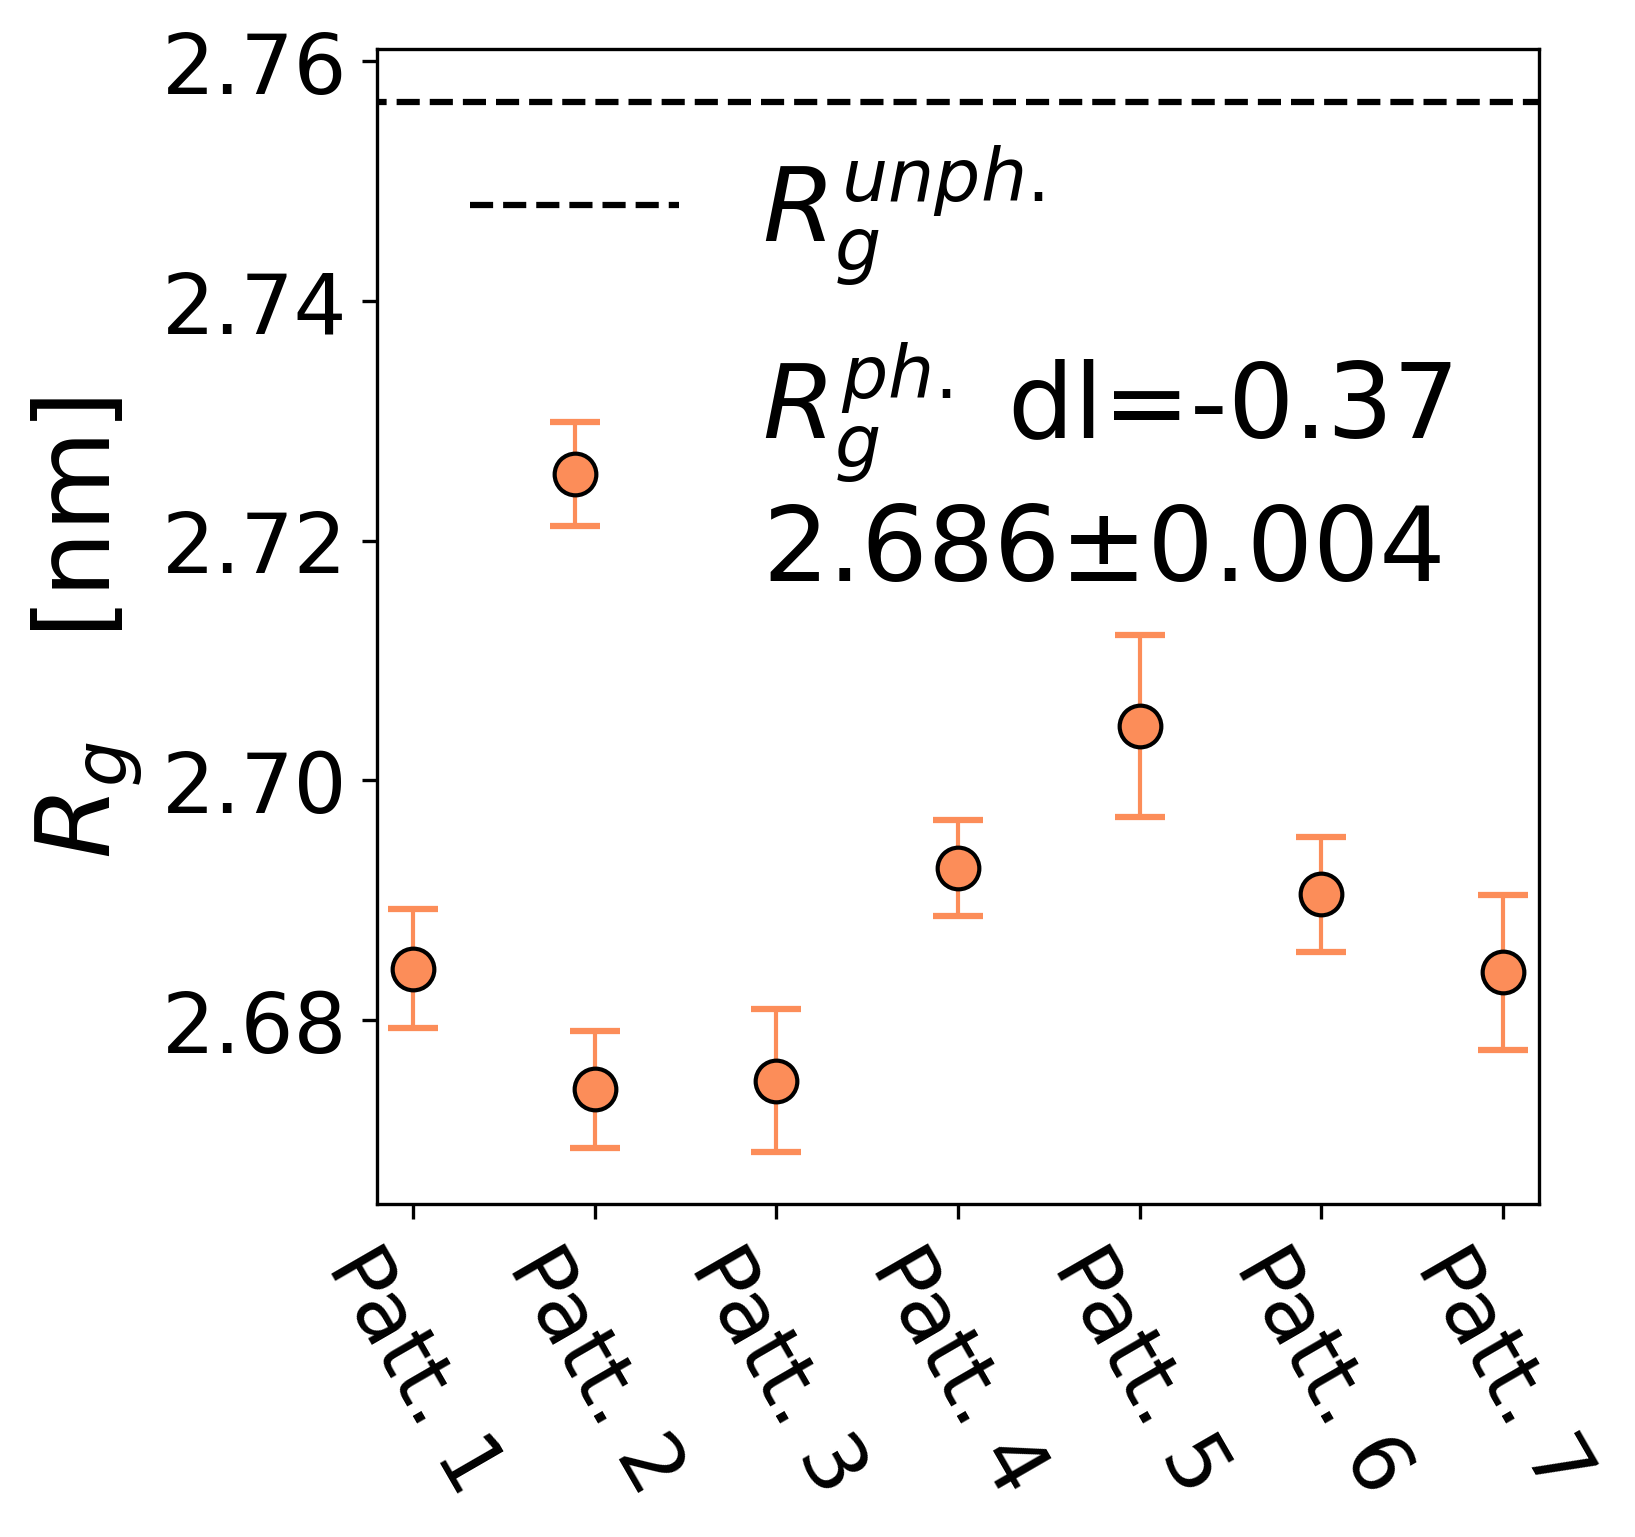

In [ ]:
proteins_ppos

fig, axs = plt.subplots(1,1,figsize=(5,5),dpi=300)
x_axis = np.arange(len(proteins_ppos.index))
axs.errorbar(x=x_axis,
                y=proteins_ppos['rg'],
                yerr=proteins_ppos['rg_err'],
                #width=0.3,
                marker='o',ms=10,elinewidth=1,capsize=6,capthick=1.5,ls='',
                label = '$R_{g}^{ph}$ dl=-0.37'+F"\n{np.mean(proteins_ppos['rg']):.3f}±{np.std(proteins_ppos['rg'])/np.sqrt(proteins_ppos['rg'].size):.3f}",
                lw=1.5,color='#fc8d59',markeredgecolor='black',zorder=0)


axs.hlines(proteins_up.loc['Sic1','rg'],-1,8,color='k',ls='--',linewidth=1.5,label="$R_{g}^{unph}$"+F"")

# Xticks
axs.set_xticks(x_axis)
axs.set_xticklabels([F"Patt. {i+1}" for i in range(len(proteins_ppos.index))],rotation=-60)
axs.tick_params(axis="x", labelsize=20) 
axs.tick_params(axis="y", labelsize=20)
axs.set_ylabel("$R_{g}$   [nm]", fontsize=25)
axs.set_xlim(-0.2,6.2)
# Add legend
axs.legend(frameon=False,title_fontsize=25,fontsize=25,loc='upper left',ncol=1);
fig.savefig("./figures/figure2__panel-D__pSic6fold-phospho-patterning.pdf",bbox_inches='tight', pad_inches=1);

### Evaluation Figures

#### Figure 3

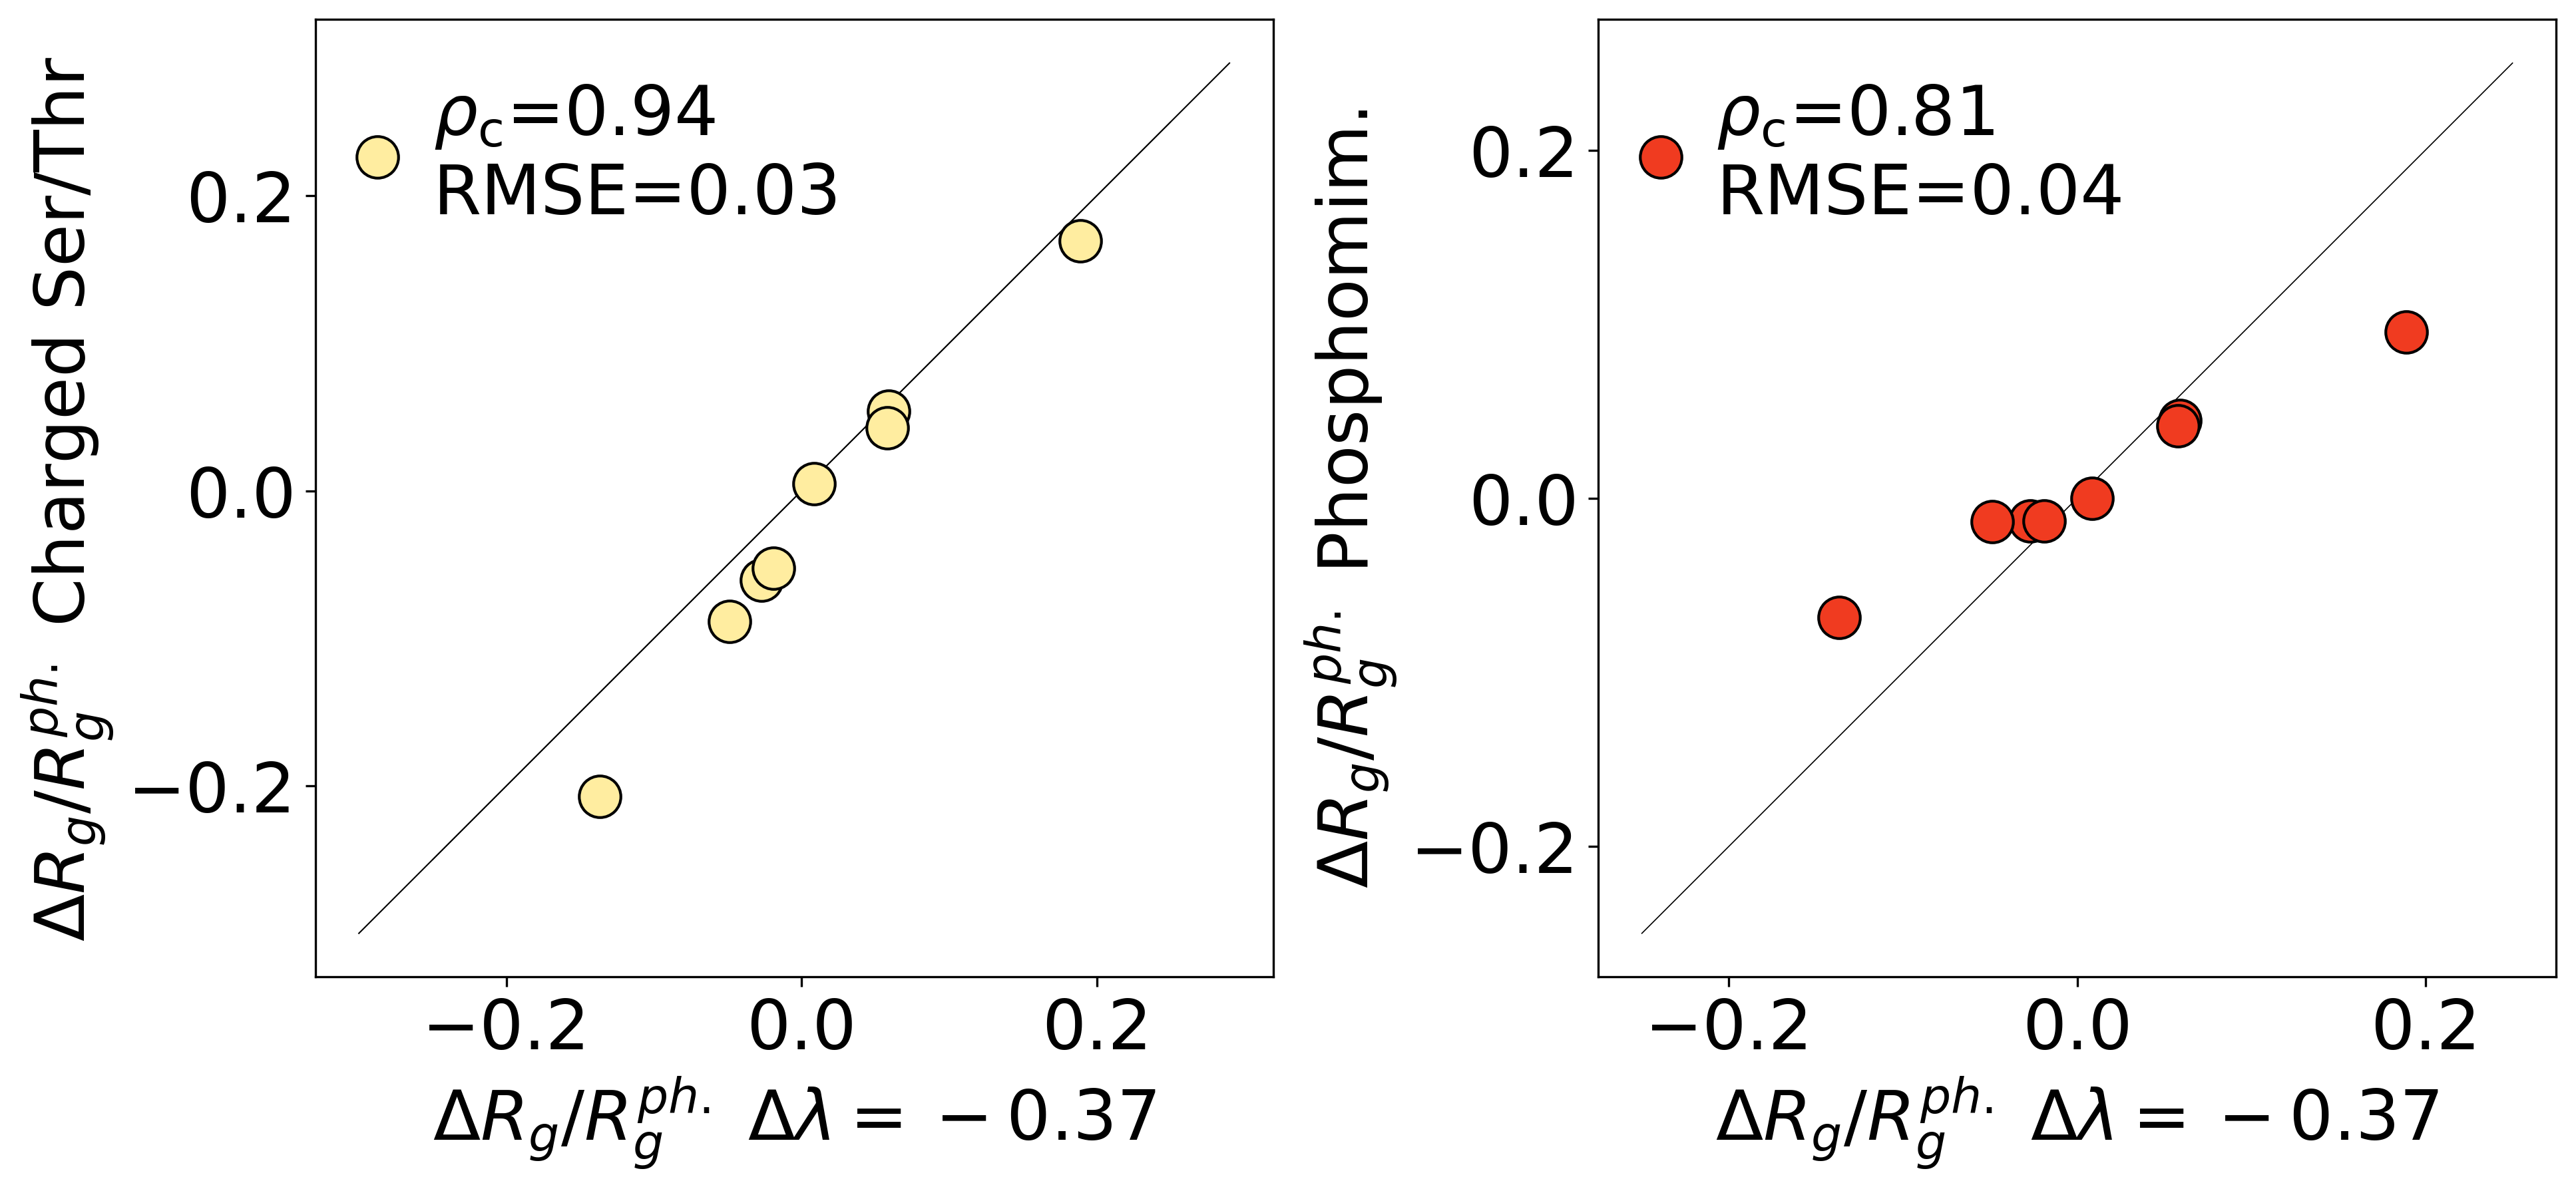

In [ ]:
names   =['10pAsh1', 'pCTD2', 'pSic-6fold', 'pSic-7fold', 'HPPAGE4', 'SN15p', 'rOPNp', 'pERa']#,'pTauS','pTauT'] #'CPPAGE4',
names_up=['Ash1', 'CTD2', 'Sic1', 'Sic1', 'WTPAGE4', 'SN15', 'rOPN', 'ERa']#, 'TauT', 'TauS']

drgs_ch  = proteins_ch.loc[names,'rg'].to_numpy()-proteins_up.loc[names_up,'rg'].to_numpy()
drgsE_ch = np.sqrt(proteins_ch.loc[names,'rg_err'].to_numpy()**2+proteins_up.loc[names_up,'rg_err'].to_numpy()**2)
ratio_ch = drgs_ch/proteins_ch.loc[names,'rg'].to_numpy()
ratio_chE= propagate_error_ratio(drgs_ch,
                                 proteins_ch.loc[names,'rg'].to_numpy(),
                                 drgsE_ch,
                                 proteins_ch.loc[names,'rg_err'].to_numpy())

rmse_ch  = rmse(y_true=df_protein.loc[(-0.37),'ratio_rg'].loc[names], y_pred=ratio_ch)

drgs_mim  = proteins_mim.loc[names,'rg'].to_numpy()-proteins_up.loc[names_up,'rg'].to_numpy()
drgsE_mim = np.sqrt(proteins_mim.loc[names,'rg_err'].to_numpy()**2+proteins_up.loc[names_up,'rg_err'].to_numpy()**2)
ratio_mim = drgs_mim/proteins_mim.loc[names,'rg'].to_numpy()
ratio_chE= propagate_error_ratio(drgs_mim,
                                 proteins_mim.loc[names,'rg'].to_numpy(),
                                 drgsE_mim,
                                 proteins_mim.loc[names,'rg_err'].to_numpy())

rmse_mim  = rmse(y_true=df_protein.loc[(-0.37),'ratio_rg'].loc[names], y_pred=ratio_mim)


fig, axs = plt.subplots(1,2,figsize=(13,8),dpi=300);

axs[0].errorbar(x=df_protein.loc[(-0.37),'ratio_rg'].loc[names],
                y=ratio_ch,
             marker='o', ls='',
             label=r"$\rho_\mathrm{c}$"+F"={calcCCC(experiment=df_protein.loc[(-0.37),'ratio_rg'].loc[names], simulation=ratio_ch):.2f}\nRMSE={rmse_ch:.2f}",
             markersize=15,capsize=5,capthick=1,elinewidth=1,color='#ffeda0', markeredgecolor='k')

axs[0].plot(np.arange(-25,26)/100,np.arange(-25,26)/100,color='k',lw=0.4)
axs[0].set_xticks([-0.2,0.0,0.2])
axs[0].set_yticks([-0.2,0.0,0.2])

axs[0].plot(np.arange(-30,30)/100,np.arange(-30,30)/100,color='k',lw=0.5)
axs[0].set_xlabel('$\Delta R_{g}/R_{g}^{ph}$ $\Delta \lambda = -0.37$', fontsize=25)
axs[0].set_ylabel('$\Delta R_{g}/R_{g}^{ph}$ Charged Ser/Thr', fontsize=25)
axs[0].tick_params(axis='y', labelsize=25)
axs[0].tick_params(axis='x', labelsize=25)
axs[0].set_aspect('equal', 'box')
axs[0].legend(fontsize=25,frameon=False,loc='upper left',alignment='left',handlelength=0);

axs[1].errorbar(x=df_protein.loc[(-0.37),'ratio_rg'].loc[names],
                y=ratio_mim,
                marker='o', ls='',
                label=r"$\rho_\mathrm{c}$"+F"={calcCCC(experiment=df_protein.loc[(-0.37),'ratio_rg'].loc[names], simulation=ratio_mim):.2f}\nRMSE={rmse_mim:.2f}",
                markersize=15,capsize=5,capthick=1,elinewidth=1,color='#f03b20', markeredgecolor='k')


axs[1].plot(np.arange(-25,26)/100,np.arange(-25,26)/100,color='k',lw=0.4)
axs[1].set_xticks([-0.2,0.0,0.2])
axs[1].set_yticks([-0.2,0.0,0.2])
axs[1].set_xlabel('$\Delta R_{g}/R_{g}^{ph}$ $\Delta \lambda = -0.37$', fontsize=25)
axs[1].set_ylabel('$\Delta R_{g}/R_{g}^{ph}$ Phosphomim.', fontsize=25)
axs[1].tick_params(axis='y', labelsize=25)
axs[1].tick_params(axis='x', labelsize=25)
axs[1].set_aspect('equal', 'box')
axs[1].legend(fontsize=25,frameon=False,loc='upper left',alignment='left',handlelength=0);

fig.tight_layout();
fig.savefig("./figures/figure3__evaluation-plots_V2.pdf",bbox_inches='tight', pad_inches=1);

#### Figure S1

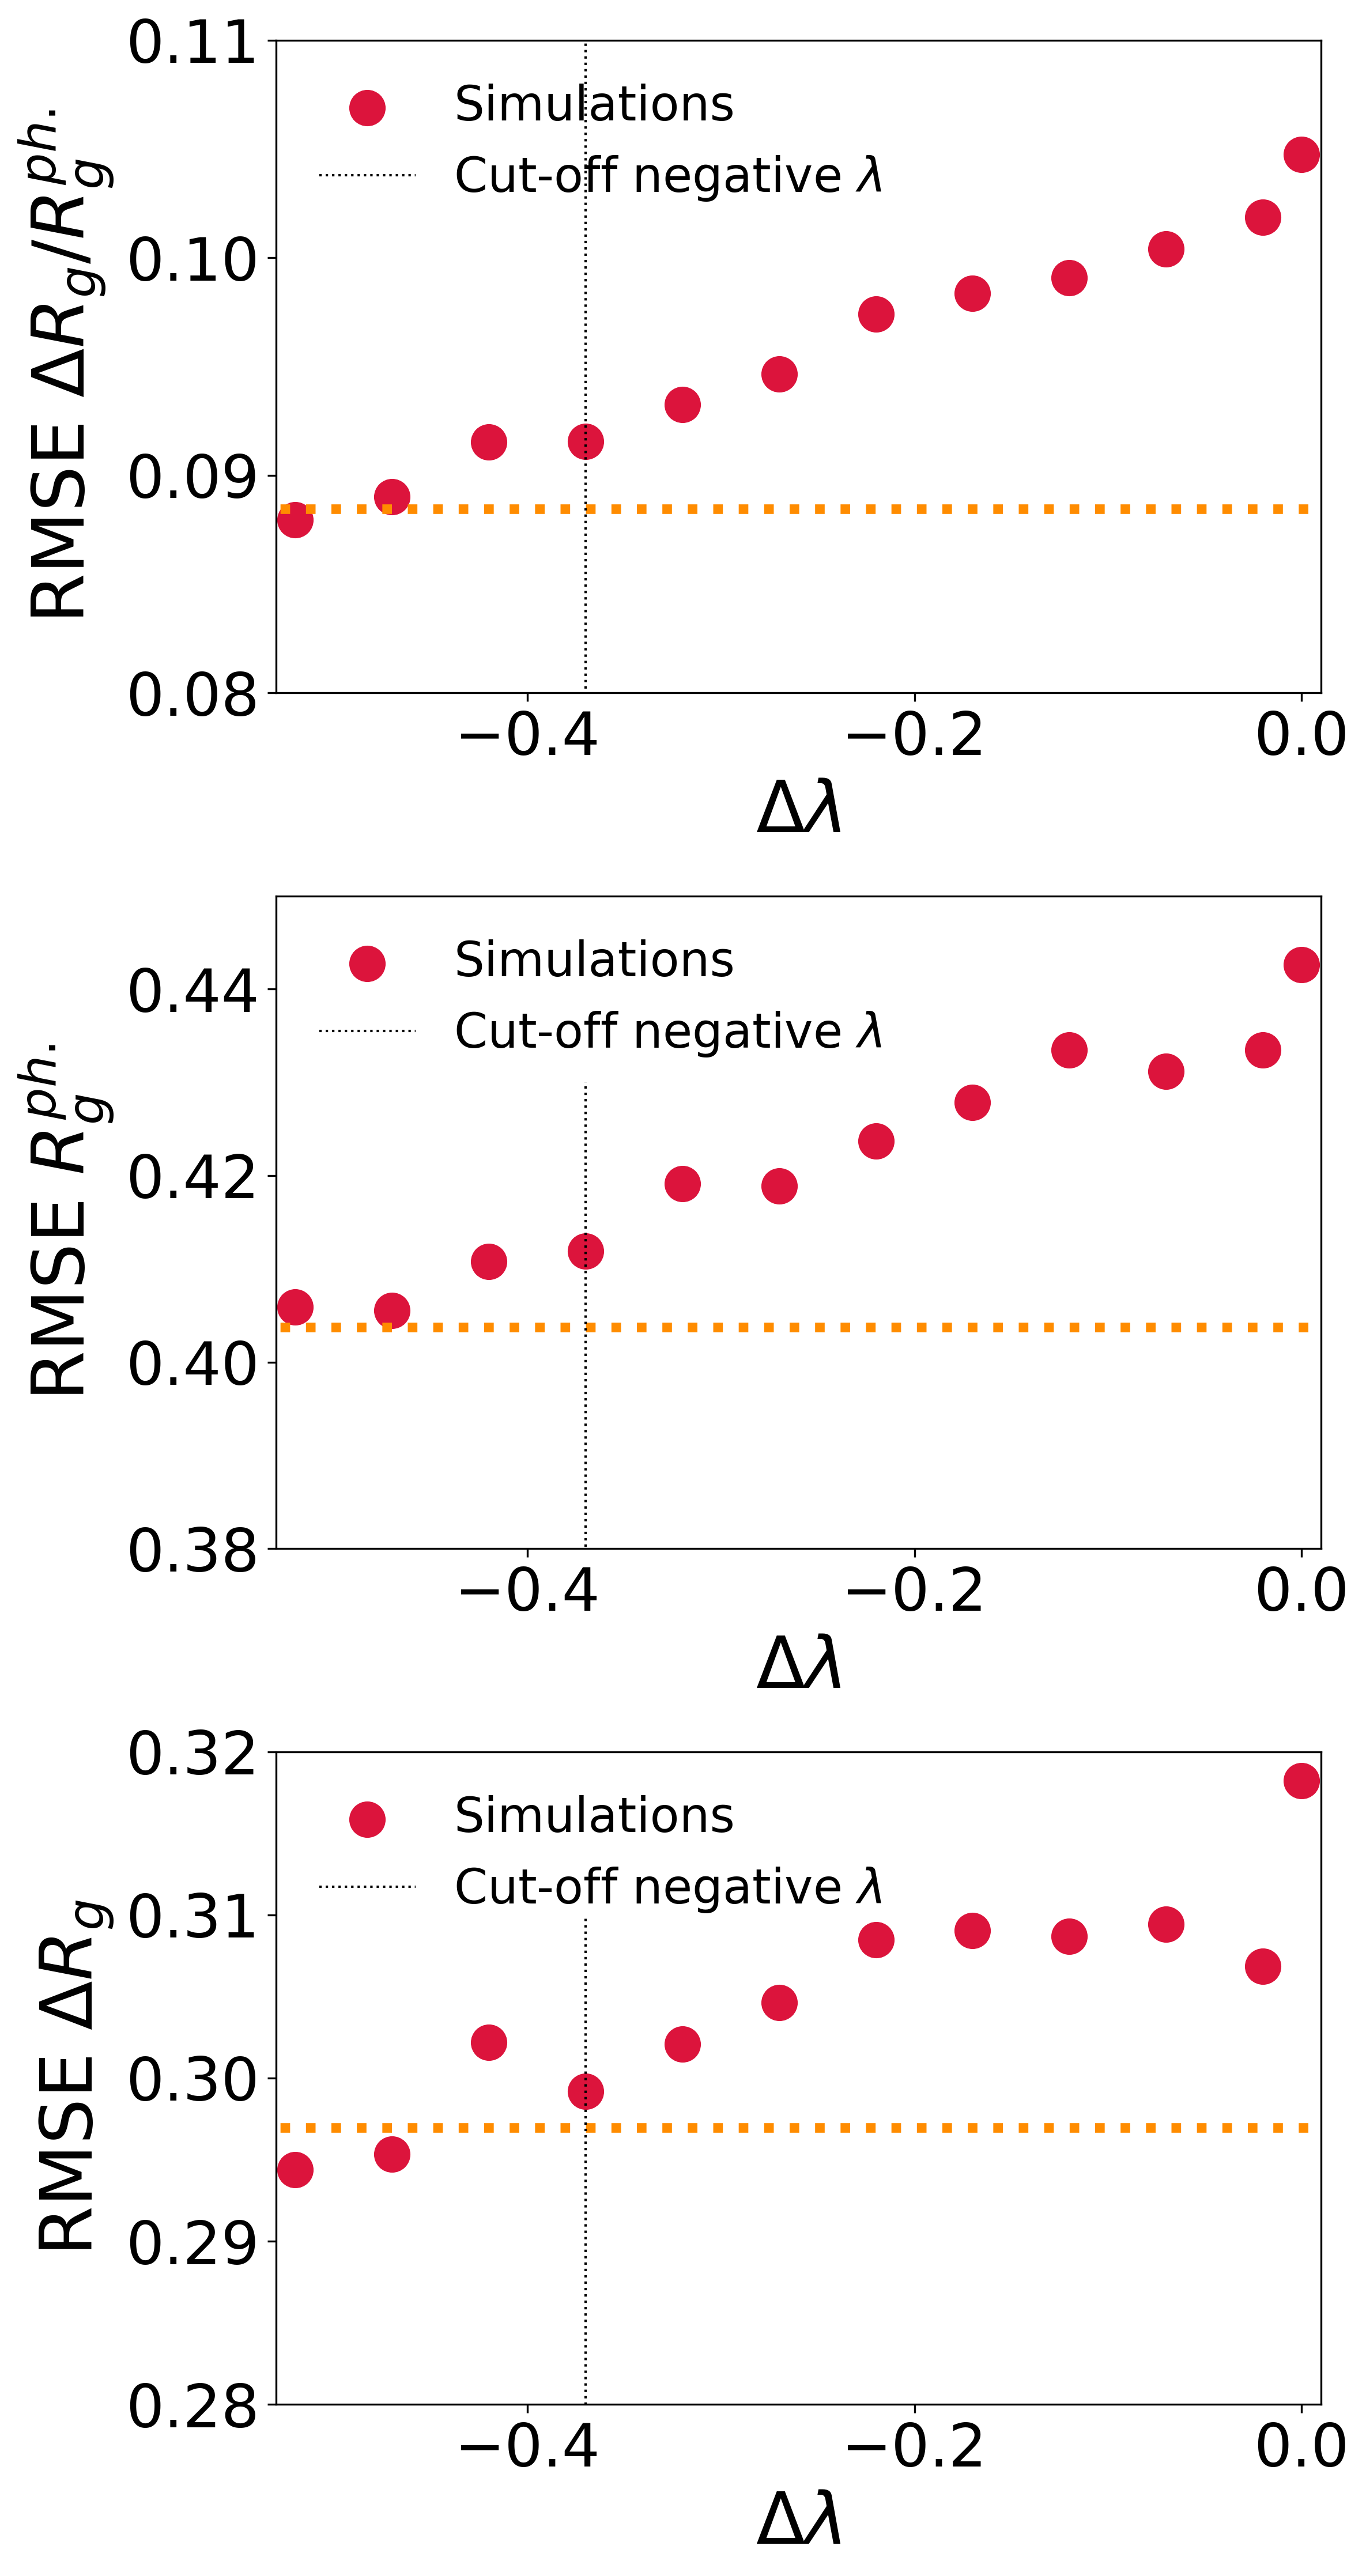

In [ ]:
prots_rg_new = ['10pAsh1', 'pCTD2', 'pSic-6fold', 'pSic-7fold', 'HPPAGE4', 'SN15p', 'rOPNp', 'pERa']
df_temp = evaluate_target(protein_names=prots_rg_new, data=df_protein, target='ratio')


fig, axs = plt.subplots(3,1,figsize=(8,15),dpi=300);

targ = 'ratio'
met = 'rmse'
lab='RMSE $\Delta R_{g}/R_{g}^{ph}$'
df_temp = evaluate_target(protein_names=prots_rg_new, data=df_protein, target=targ)
xs=np.array([np.round(float(i),2) for i in df_temp.index])
ys=df_temp[met]
axs[0].hlines(np.mean(ys.to_numpy()[-30:-10]),xs[0],xs[-1]+0.05,linewidth=4,ls=':',color='darkorange')
axs[0].scatter(x=xs, y=ys, s=200, c='crimson',label=F"Simulations")# - w/o: CPPAGE4")
axs[0].vlines(-0.37,ys.min()-0.05,0.14,ls=':',linewidth=1,color='k',label='Cut-off negative $\lambda$') #ys.max()+0.05
axs[0].set_ylabel(F"{lab}",fontsize=30)
axs[0].tick_params(axis='y', labelsize=25)
axs[0].set_xlabel("$\Delta \lambda$",fontsize=30)
axs[0].tick_params(axis='x', labelsize=25)
axs[0].set_xlim(-.53,0.01)
axs[0].set_ylim(0.08,0.11)
axs[0].legend(fontsize=20,ncol=1,frameon=False,loc='upper left');


targ = 'rg'
met = 'rmse'
lab='RMSE $R_{g}^{ph}$'
df_temp = evaluate_target(protein_names=prots_rg_new, data=df_protein, target=targ)
xs=np.array([np.round(float(i),2) for i in df_temp.index])
ys=df_temp[met]
axs[1].hlines(np.mean(ys.to_numpy()[-30:-10]),xs[0],xs[-1]+0.05,linewidth=4,ls=':',color='darkorange')
axs[1].scatter(x=xs, y=ys, s=200, c='crimson',label=F"Simulations")# - w/o: CPPAGE4")
axs[1].vlines(-0.37,ys.min()-0.05,0.43,ls=':',linewidth=1,color='k',label='Cut-off negative $\lambda$') #ys.max()+0.05
axs[1].set_ylabel(F"{lab}",fontsize=30)
axs[1].tick_params(axis='y', labelsize=25)
axs[1].set_xlabel("$\Delta \lambda$",fontsize=30)
axs[1].tick_params(axis='x', labelsize=25)
axs[1].set_xlim(-.53,0.01)
axs[1].set_ylim(0.38,0.45)
axs[1].legend(fontsize=20,ncol=1,frameon=False,loc='upper left');


targ = 'drg'
met = 'rmse'
lab='RMSE $\Delta R_{g}$'
df_temp = evaluate_target(protein_names=prots_rg_new, data=df_protein, target=targ)
xs=np.array([np.round(float(i),2) for i in df_temp.index])
ys=df_temp[met]
axs[2].hlines(np.mean(ys.to_numpy()[-30:-10]),xs[0],xs[-1]+0.05,linewidth=4,ls=':',color='darkorange')
axs[2].scatter(x=xs, y=ys, s=200, c='crimson',label=F"Simulations")# - w/o: CPPAGE4")
axs[2].vlines(-0.37,ys.min()-0.05,0.31,ls=':',linewidth=1,color='k',label='Cut-off negative $\lambda$') #ys.max()+0.05
axs[2].set_ylabel(F"{lab}",fontsize=30)
axs[2].tick_params(axis='y', labelsize=25)
axs[2].set_xlabel("$\Delta \lambda$",fontsize=30)
axs[2].tick_params(axis='x', labelsize=25)
axs[2].set_xlim(-.53,0.01)
axs[2].set_ylim(0.28,0.32)
axs[2].legend(fontsize=20,ncol=1,frameon=False,loc='upper left');


fig.tight_layout()
fig.savefig("./figures/SI-figure__RMSE-ratio-rg-drg.pdf",bbox_inches='tight', pad_inches=1);

#### Figure S2

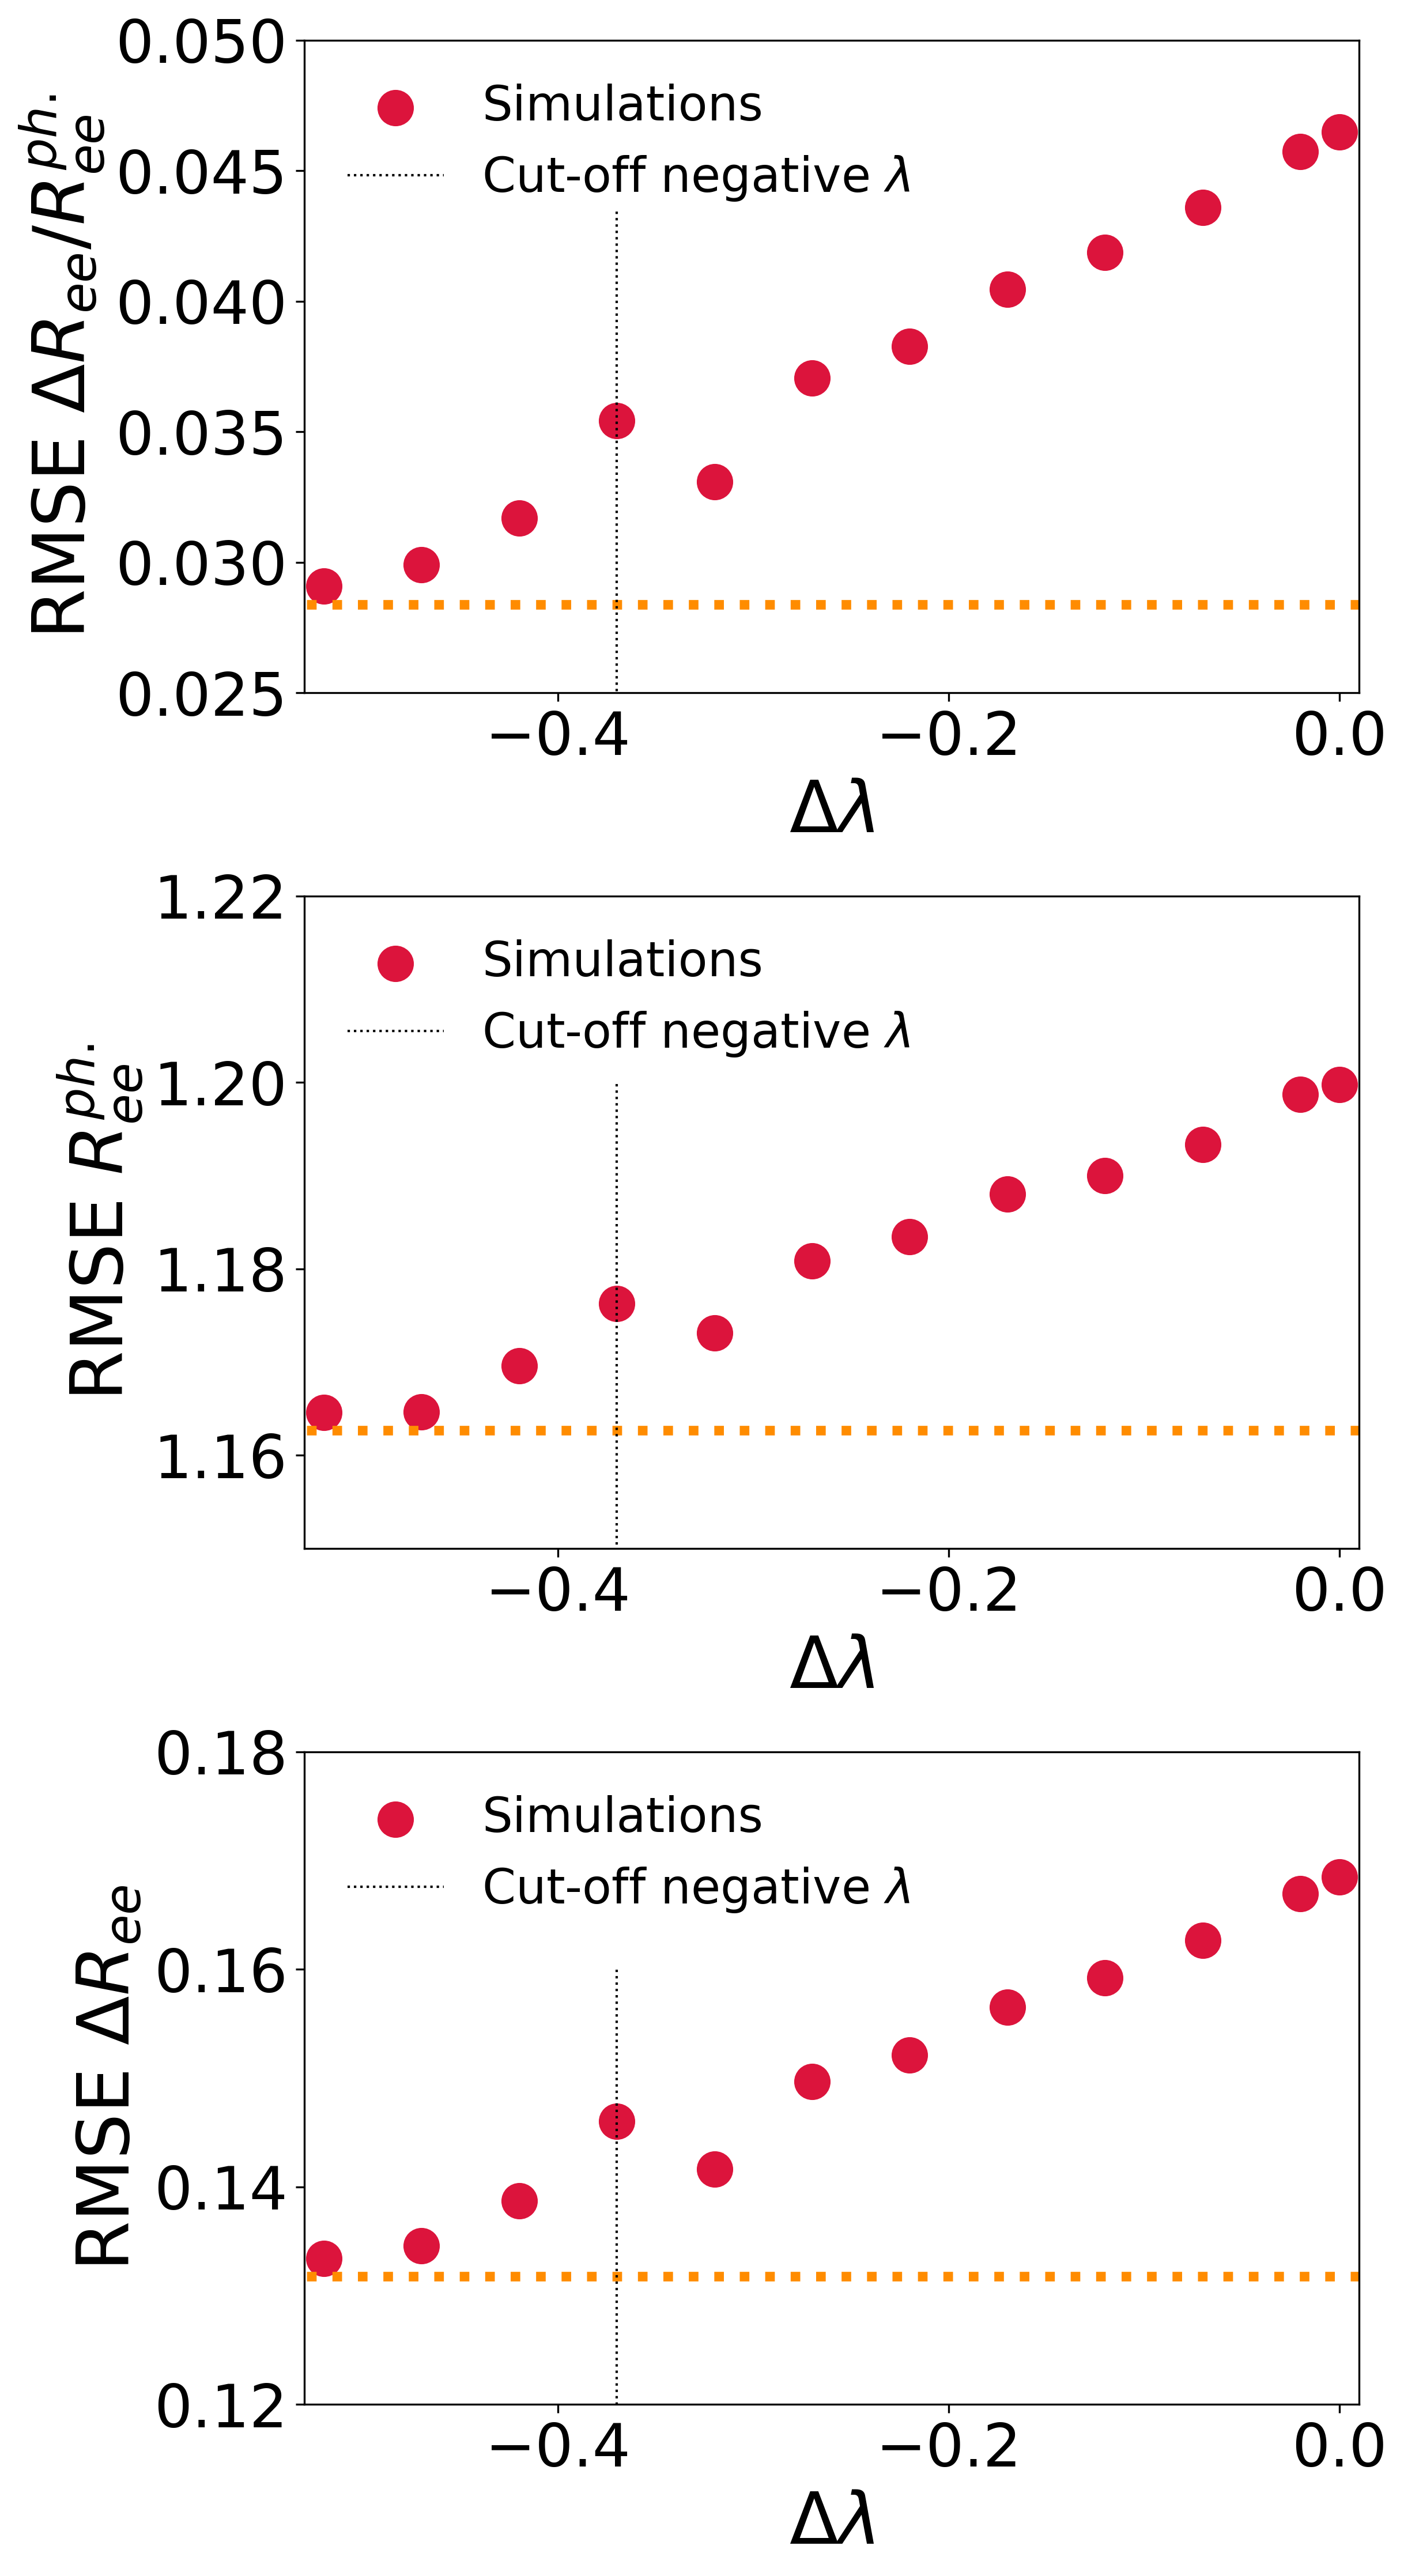

In [ ]:
prots_rg_new = ['10pAsh1', 'pCTD2', 'pSic-6fold', 'pSic-7fold', 'HPPAGE4', 'SN15p', 'rOPNp', 'pERa']
df_temp = evaluate_target(protein_names=prots_rg_new, data=df_protein, target='ratio')


fig, axs = plt.subplots(3,1,figsize=(8,15),dpi=300);

targ = 'ratio'
met = 'rmse'
lab='RMSE $\Delta R_{ee}/R_{ee}^{ph}$'
df_temp = evaluate_target(protein_names=prots_ree, data=df_protein_ree, target=targ)
xs=np.array([np.round(float(i),2) for i in df_temp.index])
ys=df_temp[met]
axs[0].hlines(np.mean(ys.to_numpy()[-30:-10]),xs[0],xs[-1]+0.05,linewidth=4,ls=':',color='darkorange')
axs[0].scatter(x=xs, y=ys, s=200, c='crimson',label=F"Simulations")# - w/o: CPPAGE4")
axs[0].vlines(-0.37,ys.min()-0.05,0.0435,ls=':',linewidth=1,color='k',label='Cut-off negative $\lambda$') #ys.max()+0.05
axs[0].set_ylabel(F"{lab}",fontsize=30)
axs[0].tick_params(axis='y', labelsize=25)
axs[0].set_xlabel("$\Delta \lambda$",fontsize=30)
axs[0].tick_params(axis='x', labelsize=25)
axs[0].set_xlim(-.53,0.01)
axs[0].set_ylim(0.025,0.05)
axs[0].legend(fontsize=20,ncol=1,frameon=False,loc='upper left');


targ = 'ree'
met = 'rmse'
lab='RMSE $R_{ee}^{ph}$'
df_temp = evaluate_target(protein_names=prots_ree, data=df_protein_ree, target=targ)
xs=np.array([np.round(float(i),2) for i in df_temp.index])
ys=df_temp[met]
axs[1].hlines(np.mean(ys.to_numpy()[-30:-10]),xs[0],xs[-1]+0.05,linewidth=4,ls=':',color='darkorange')
axs[1].scatter(x=xs, y=ys, s=200, c='crimson',label=F"Simulations")# - w/o: CPPAGE4")
axs[1].vlines(-0.37,ys.min()-0.05,1.2,ls=':',linewidth=1,color='k',label='Cut-off negative $\lambda$') #ys.max()+0.05
axs[1].set_ylabel(F"{lab}",fontsize=30)
axs[1].tick_params(axis='y', labelsize=25)
axs[1].set_xlabel("$\Delta \lambda$",fontsize=30)
axs[1].tick_params(axis='x', labelsize=25)
axs[1].set_xlim(-.53,0.01)
axs[1].set_ylim(1.15,1.22)
axs[1].legend(fontsize=20,ncol=1,frameon=False,loc='upper left');


targ = 'dree'
met = 'rmse'
lab='RMSE $\Delta R_{ee}$'
df_temp = evaluate_target(protein_names=prots_ree, data=df_protein_ree, target=targ)
xs=np.array([np.round(float(i),2) for i in df_temp.index])
ys=df_temp[met]
axs[2].hlines(np.mean(ys.to_numpy()[-30:-10]),xs[0],xs[-1]+0.05,linewidth=4,ls=':',color='darkorange')
axs[2].scatter(x=xs, y=ys, s=200, c='crimson',label=F"Simulations")# - w/o: CPPAGE4")
axs[2].vlines(-0.37,ys.min()-0.05,0.16,ls=':',linewidth=1,color='k',label='Cut-off negative $\lambda$') #ys.max()+0.05
axs[2].set_ylabel(F"{lab}",fontsize=30)
axs[2].tick_params(axis='y', labelsize=25)
axs[2].set_xlabel("$\Delta \lambda$",fontsize=30)
axs[2].tick_params(axis='x', labelsize=25)
axs[2].set_xlim(-.53,0.01)
axs[2].set_ylim(0.12,0.18)
axs[2].legend(fontsize=20,ncol=1,frameon=False,loc='upper left');


fig.tight_layout()
fig.savefig("./figures/SI-figure__RMSE-ratio-ree-dree.pdf",bbox_inches='tight', pad_inches=1);

#### Figure S3

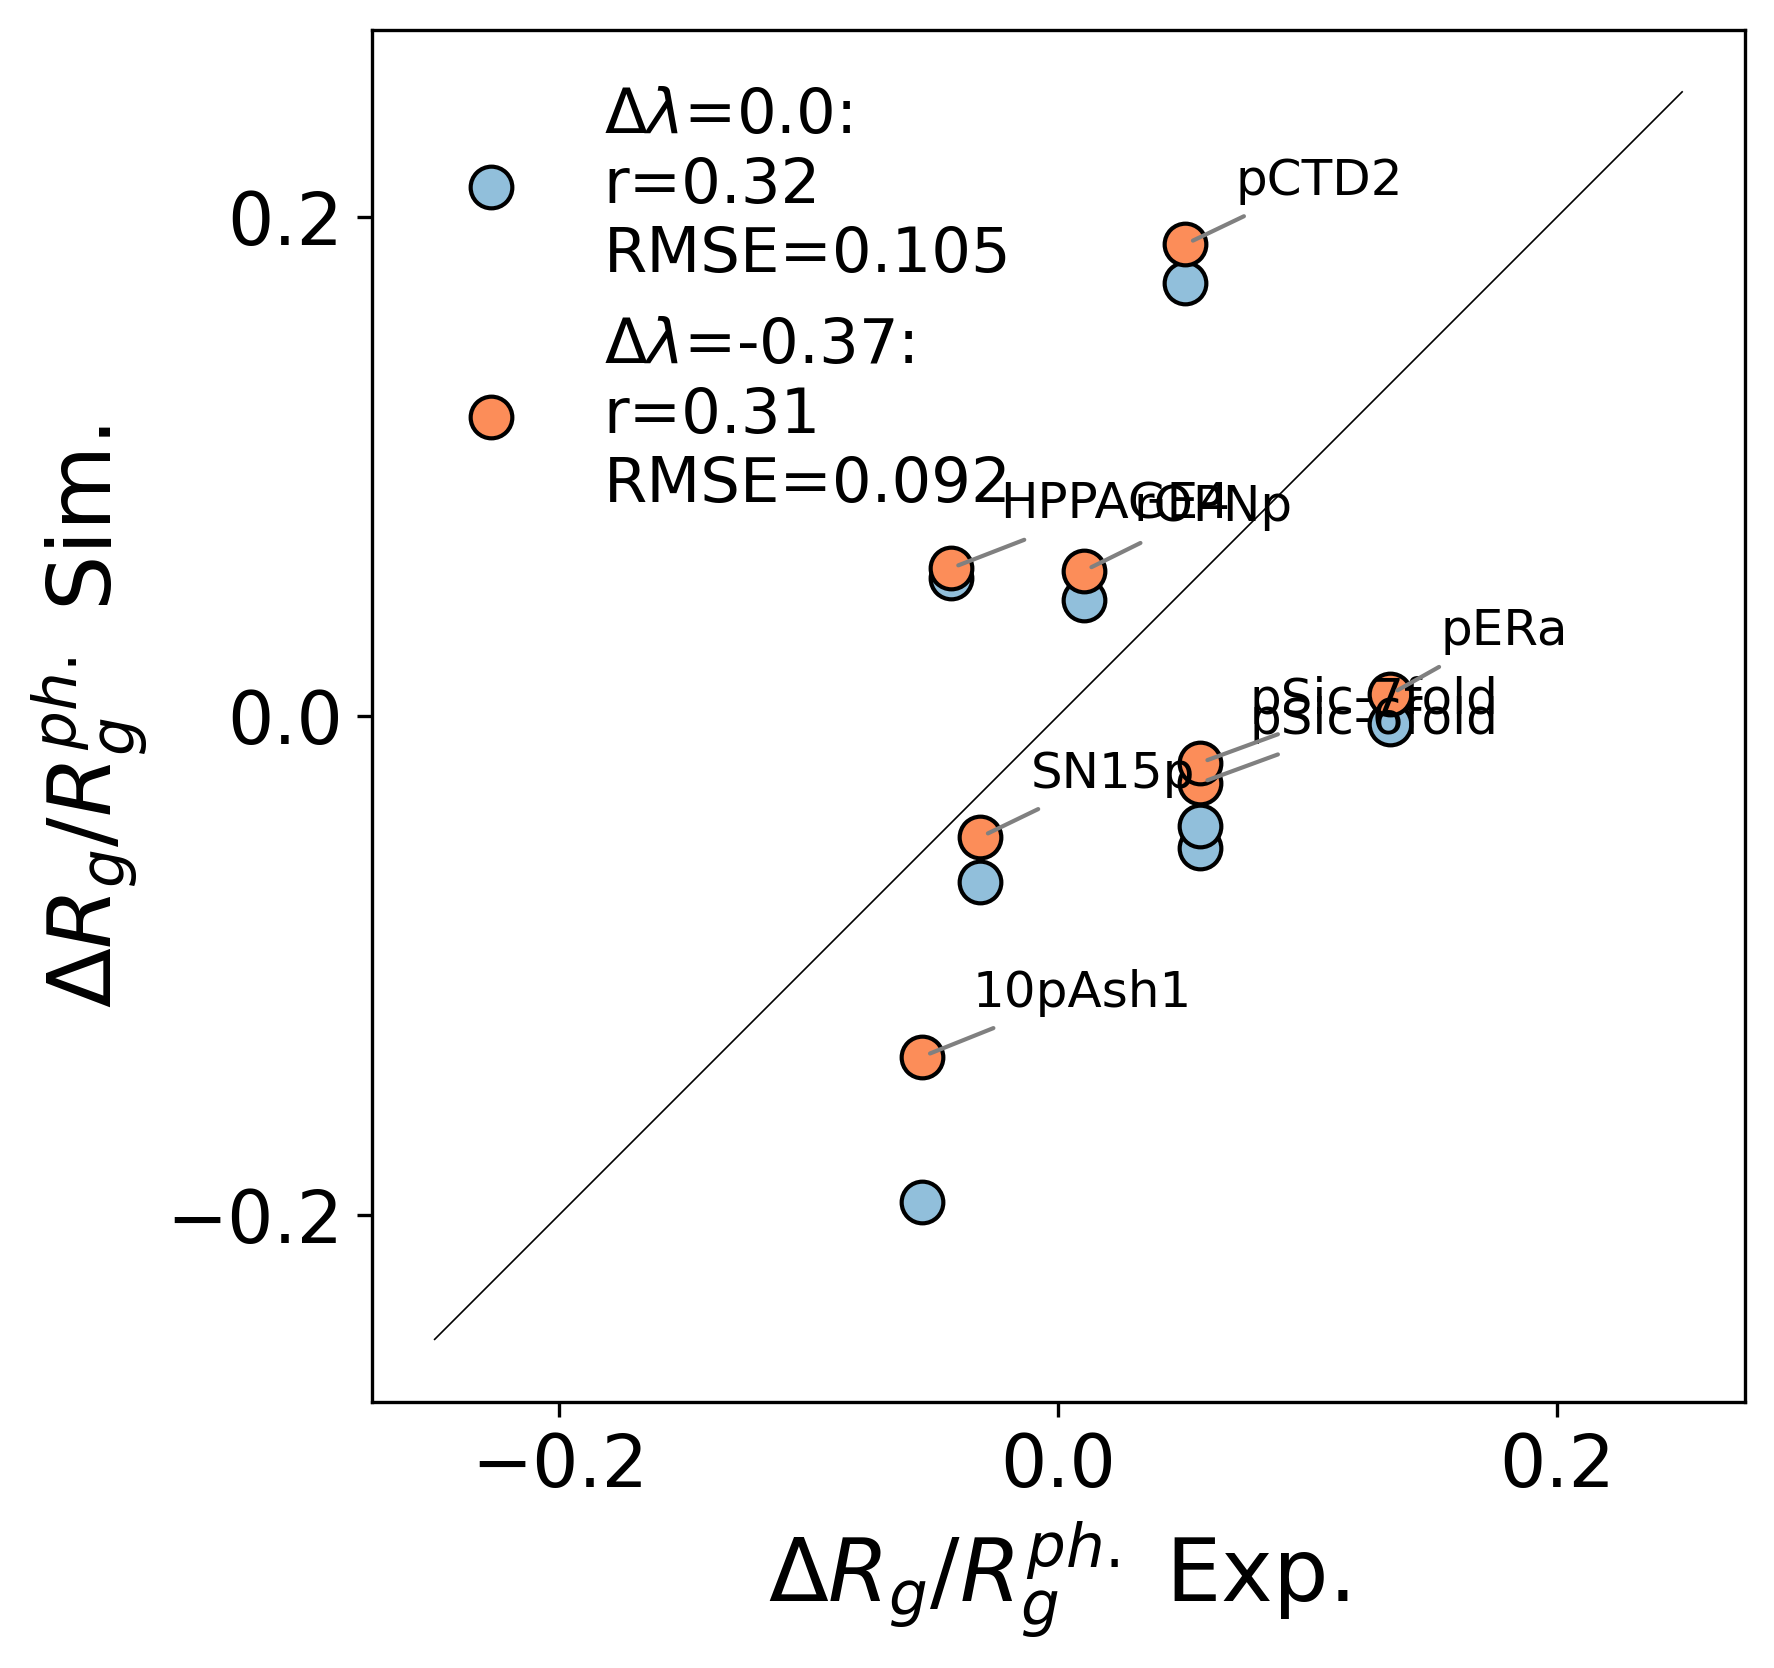

In [ ]:
prots_rg_new = ['10pAsh1', 'pCTD2', 'pSic-6fold', 'pSic-7fold', 'HPPAGE4', 'SN15p', 'rOPNp', 'pERa']
df_temp = evaluate_target(protein_names=prots_rg_new, data=df_protein, target='ratio')


fig, axs = plt.subplots(1,1,figsize=(6,6),dpi=300);

### Simulatio vs. Experiement
axs.errorbar(x=df_protein.loc[(0.0),'exp_ratio_rg'].loc[prots_rg_new],
             y=df_protein.loc[(0.0),'ratio_rg'].loc[prots_rg_new],
             marker='o', ls='',
             label="$\Delta \lambda$=0.0:\n"+F"r={pearsonr(df_protein.loc[(0.0),'exp_ratio_rg'].loc[prots_rg_new],df_protein.loc[(0.0),'ratio_rg'].loc[prots_rg_new]).statistic:.2f}\nRMSE={df_temp.loc[0.0,'rmse']:.3f}",
             markersize=10,capsize=5,capthick=1,elinewidth=1,color='#91bfdb', markeredgecolor='k')


axs.errorbar(x=df_protein.loc[(-0.37),'exp_ratio_rg'].loc[prots_rg_new],
             y=df_protein.loc[(-0.37),'ratio_rg'].loc[prots_rg_new],
             marker='o', ls='',
             label="$\Delta \lambda$=-0.37:\n"+F"r={pearsonr(df_protein.loc[(-0.37),'exp_ratio_rg'].loc[prots_rg_new],df_protein.loc[(-0.37),'ratio_rg'].loc[prots_rg_new]).statistic:.2f}\nRMSE={df_temp.loc[-0.37,'rmse']:.3f}",
             markersize=10,capsize=5,capthick=1,elinewidth=1,color='#fc8d59', markeredgecolor='k')

# Add labels with lines connecting to points
for i, label in enumerate(prots_rg_new):
    axs.annotate(
        label,
        (df_protein.loc[(-0.37),'exp_ratio_rg'].loc[prots_rg_new][i],
         df_protein.loc[(-0.37),'ratio_rg'].loc[prots_rg_new][i]),  # Point coordinates
        xytext=(df_protein.loc[(-0.37),'exp_ratio_rg'].loc[prots_rg_new][i] + 0.02, df_protein.loc[(-0.37),'ratio_rg'].loc[prots_rg_new][i] + 0.02),  # Label position
        textcoords='data',
        fontsize=12,
        arrowprops=dict(arrowstyle="-", color='gray', lw=1)  # Line connecting point and label
    )

axs.plot(np.arange(-25,26)/100,np.arange(-25,26)/100,color='k',lw=0.4)
axs.set_xlabel('$\Delta R_{g}/R_{g}^{ph}$ Exp.',fontsize=30*corr)
axs.set_ylabel('$\Delta R_{g}/R_{g}^{ph}$ Sim.',fontsize=30*corr)
axs.tick_params(axis='y', labelsize=25*corr)
axs.tick_params(axis='x', labelsize=25*corr)
axs.set_xticks([-0.2,0.0,0.2])
axs.set_yticks([-0.2,0.0,0.2])
axs.legend(fontsize=15,loc='upper left',ncol=1,frameon=False);
axs.set_aspect('equal', 'box');

fig.tight_layout()
fig.savefig("./figures/SI-figure__ratio-sim-v-exp__labels_V2.pdf",bbox_inches='tight', pad_inches=1);

#### Figure S4

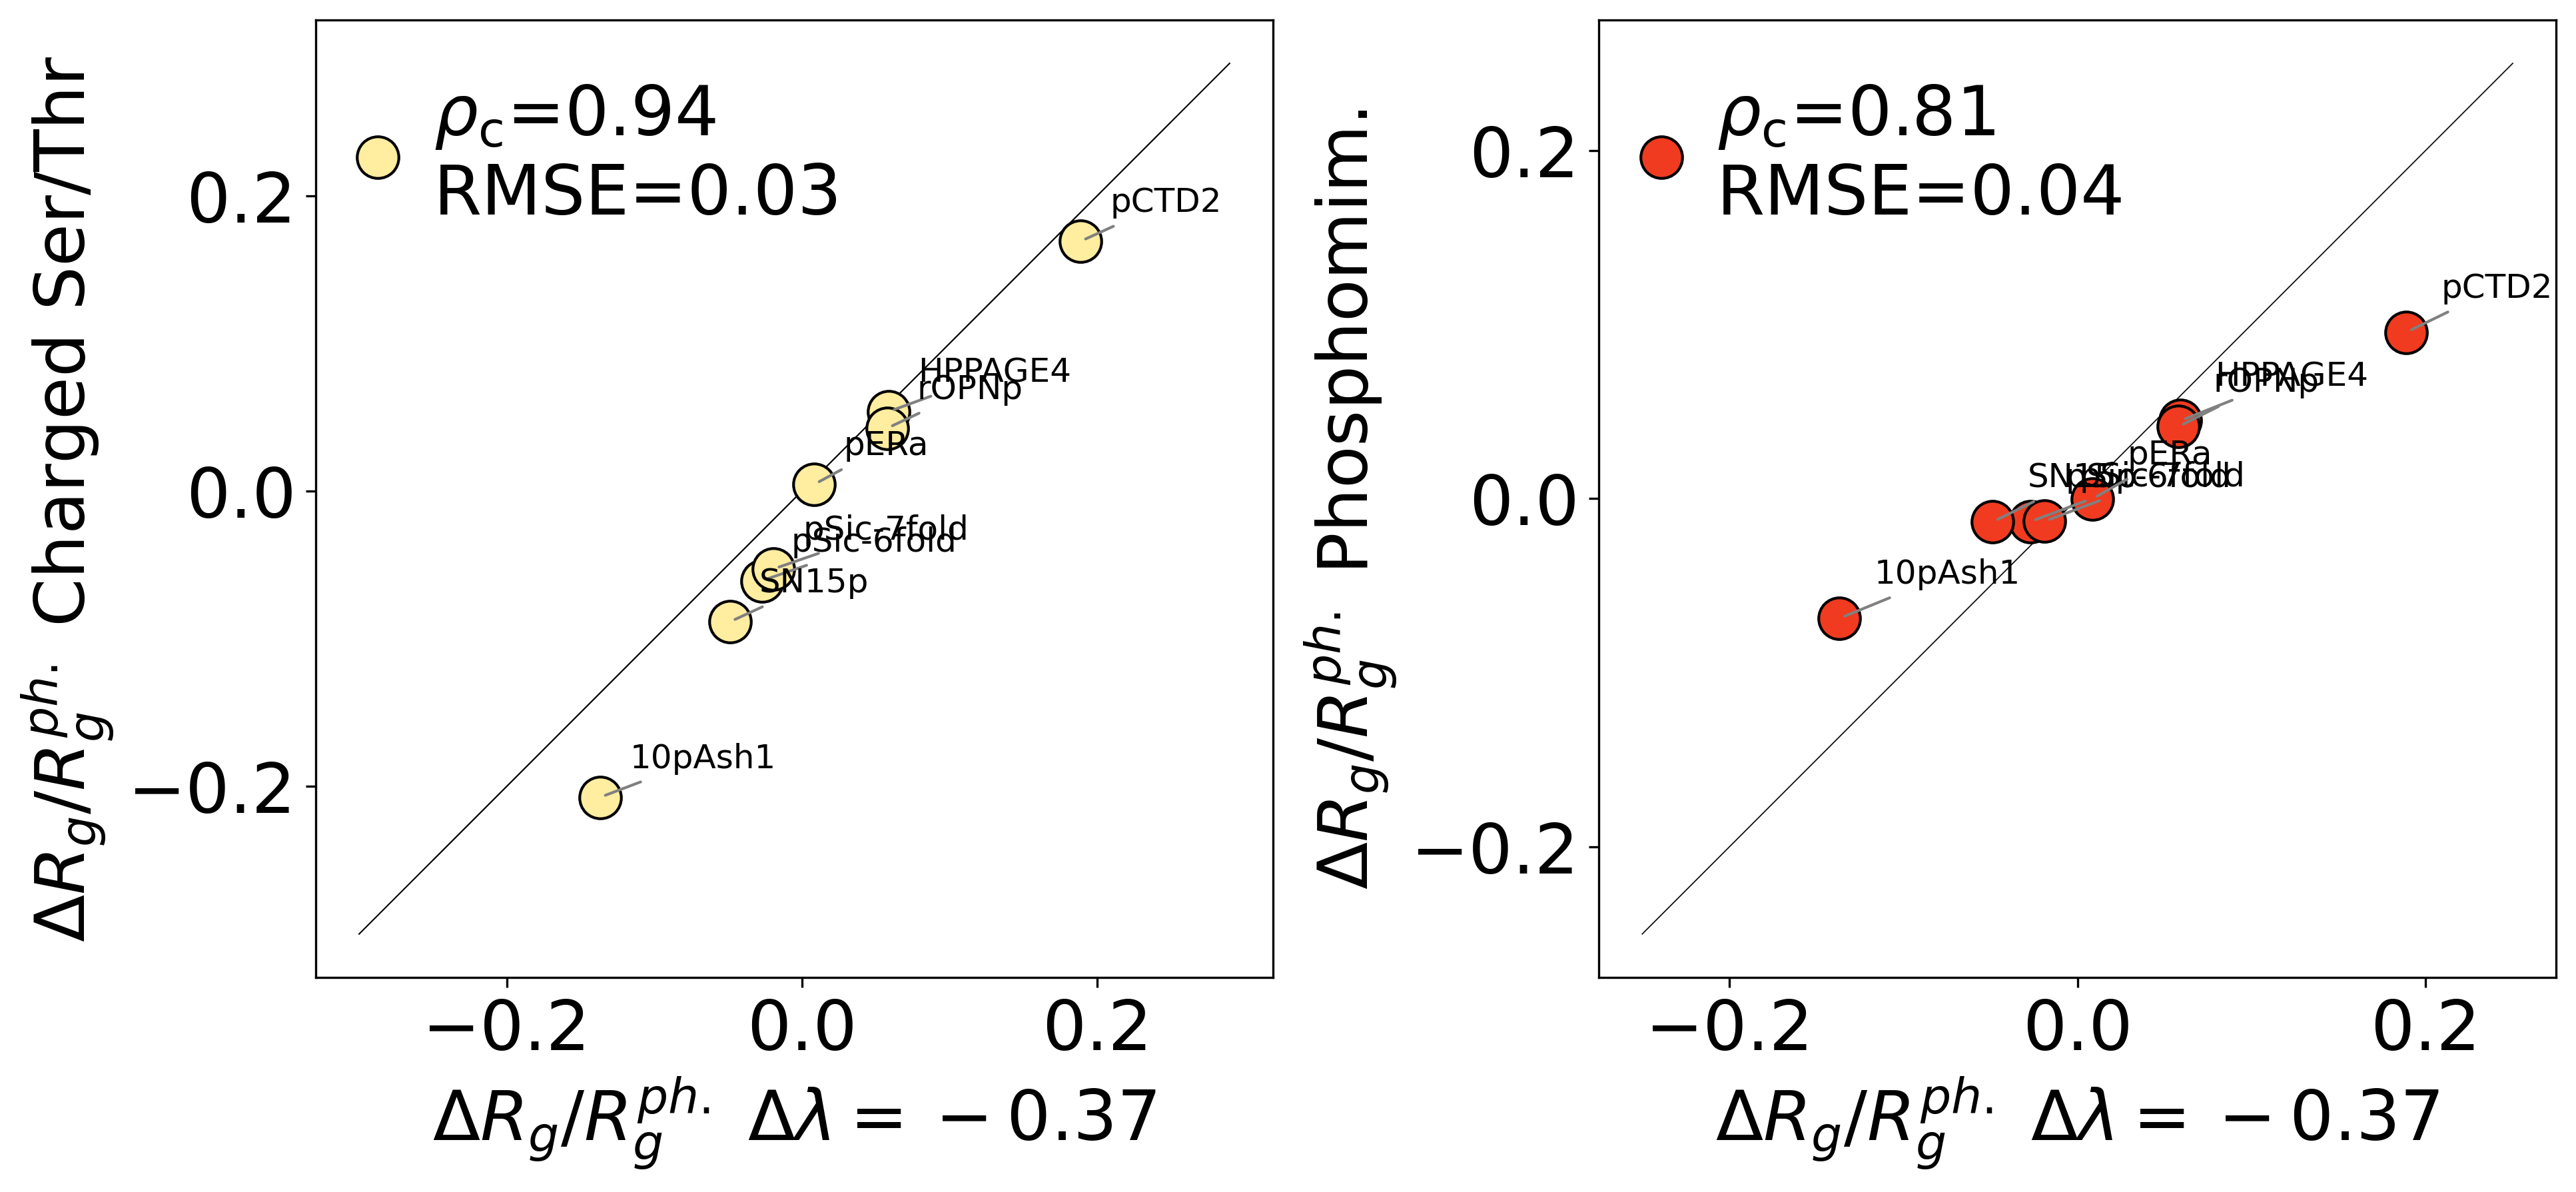

In [ ]:
names   =['10pAsh1', 'pCTD2', 'pSic-6fold', 'pSic-7fold', 'HPPAGE4', 'SN15p', 'rOPNp', 'pERa']#,'pTauS','pTauT'] #'CPPAGE4',
names_up=['Ash1', 'CTD2', 'Sic1', 'Sic1', 'WTPAGE4', 'SN15', 'rOPN', 'ERa']#, 'TauT', 'TauS']

drgs_ch  = proteins_ch.loc[names,'rg'].to_numpy()-proteins_up.loc[names_up,'rg'].to_numpy()
drgsE_ch = np.sqrt(proteins_ch.loc[names,'rg_err'].to_numpy()**2+proteins_up.loc[names_up,'rg_err'].to_numpy()**2)
ratio_ch = drgs_ch/proteins_ch.loc[names,'rg'].to_numpy()
ratio_chE= propagate_error_ratio(drgs_ch,
                                 proteins_ch.loc[names,'rg'].to_numpy(),
                                 drgsE_ch,
                                 proteins_ch.loc[names,'rg_err'].to_numpy())

rmse_ch  = rmse(y_true=df_protein.loc[(-0.37),'ratio_rg'].loc[names], y_pred=ratio_ch)

drgs_mim  = proteins_mim.loc[names,'rg'].to_numpy()-proteins_up.loc[names_up,'rg'].to_numpy()
drgsE_mim = np.sqrt(proteins_mim.loc[names,'rg_err'].to_numpy()**2+proteins_up.loc[names_up,'rg_err'].to_numpy()**2)
ratio_mim = drgs_mim/proteins_mim.loc[names,'rg'].to_numpy()
ratio_chE= propagate_error_ratio(drgs_mim,
                                 proteins_mim.loc[names,'rg'].to_numpy(),
                                 drgsE_mim,
                                 proteins_mim.loc[names,'rg_err'].to_numpy())

rmse_mim  = rmse(y_true=df_protein.loc[(-0.37),'ratio_rg'].loc[names], y_pred=ratio_mim)



fig, axs = plt.subplots(1,2,figsize=(13,8),dpi=300);

axs[0].errorbar(x=df_protein.loc[(-0.37),'ratio_rg'].loc[names],
                y=ratio_ch,
                marker='o', ls='',
                label=r"$\rho_\mathrm{c}$"+F"={calcCCC(experiment=df_protein.loc[(-0.37),'ratio_rg'].loc[names], simulation=ratio_ch):.2f}\nRMSE={rmse_ch:.2f}",
                markersize=15,capsize=5,capthick=1,elinewidth=1,color='#ffeda0', markeredgecolor='k')

axs[0].plot(np.arange(-25,26)/100,np.arange(-25,26)/100,color='k',lw=0.4)
axs[0].set_xticks([-0.2,0.0,0.2])
axs[0].set_yticks([-0.2,0.0,0.2])

axs[0].plot(np.arange(-30,30)/100,np.arange(-30,30)/100,color='k',lw=0.5)
axs[0].set_xlabel('$\Delta R_{g}/R_{g}^{ph}$ $\Delta \lambda = -0.37$', fontsize=25)
axs[0].set_ylabel('$\Delta R_{g}/R_{g}^{ph}$ Charged Ser/Thr', fontsize=25) #Ser$^{-2}$/Thr$^{-2}$
axs[0].tick_params(axis='y', labelsize=25)
axs[0].tick_params(axis='x', labelsize=25)
axs[0].set_aspect('equal', 'box')
axs[0].legend(fontsize=25,frameon=False,loc='upper left',alignment='left',handlelength=0);

# Add labels with lines connecting to points
for i, label in enumerate(prots_rg_new):
    axs[0].annotate(
        label,
        (df_protein.loc[(-0.37),'ratio_rg'].loc[prots_rg_new][i],ratio_ch[i]),  # Point coordinates
        xytext=(df_protein.loc[(-0.37),'ratio_rg'].loc[prots_rg_new][i] + 0.02, ratio_ch[i] + 0.02),  # Label position
        textcoords='data',
        fontsize=12,
        arrowprops=dict(arrowstyle="-", color='gray', lw=1)  # Line connecting point and label
    )


axs[1].errorbar(x=df_protein.loc[(-0.37),'ratio_rg'].loc[names],
                y=ratio_mim,
                marker='o', ls='',
                label=r"$\rho_\mathrm{c}$"+F"={calcCCC(experiment=df_protein.loc[(-0.37),'ratio_rg'].loc[names], simulation=ratio_mim):.2f}\nRMSE={rmse_mim:.2f}",
                markersize=15,capsize=5,capthick=1,elinewidth=1,color='#f03b20', markeredgecolor='k')


axs[1].plot(np.arange(-25,26)/100,np.arange(-25,26)/100,color='k',lw=0.4)
axs[1].set_xticks([-0.2,0.0,0.2])
axs[1].set_yticks([-0.2,0.0,0.2])
axs[1].set_xlabel('$\Delta R_{g}/R_{g}^{ph}$ $\Delta \lambda = -0.37$', fontsize=25)
axs[1].set_ylabel('$\Delta R_{g}/R_{g}^{ph}$ Phosphomim.', fontsize=25)
axs[1].tick_params(axis='y', labelsize=25)
axs[1].tick_params(axis='x', labelsize=25)
axs[1].set_aspect('equal', 'box')
axs[1].legend(fontsize=25,frameon=False,loc='upper left',alignment='left',handlelength=0);


# Add labels with lines connecting to points
for i, label in enumerate(prots_rg_new):
    axs[1].annotate(
        label,
        (df_protein.loc[(-0.37),'ratio_rg'].loc[prots_rg_new][i],ratio_mim[i]),  # Point coordinates
        xytext=(df_protein.loc[(-0.37),'ratio_rg'].loc[prots_rg_new][i] + 0.02, ratio_mim[i] + 0.02),  # Label position
        textcoords='data',
        fontsize=12,
        arrowprops=dict(arrowstyle="-", color='gray', lw=1)  # Line connecting point and label
    )

fig.tight_layout();
fig.savefig("./figures/figure3__evaluation-plots__labels_V2.pdf",bbox_inches='tight', pad_inches=1);